In [1]:
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pyBigWig
import seaborn as sns
from pybedtools import BedTool
import re

import glob as glob
import pandas as pd
import matplotlib.pyplot as plt
from collections import OrderedDict

%load_ext lab_black

In [2]:
import pybedtools

In [3]:
pybedtools.__version__

'0.8.1'

# first find some regions that I wish to visualise

In [4]:
merged_dar_path_dict = {
    x.split("/")[-1].split("__DARs.TOP2k.bed")[0]: x
    for x in glob.glob(
        "downstream_analysis/DARs/master_sub_1.FIXEDCELLS/master_sub_1.FIXEDCELLS__*TOP2k.bed"
    )
}

In [5]:
regions_dict = OrderedDict({})

for supersample, path in merged_dar_path_dict.items():
    print(supersample)
    df = pd.read_csv(path, sep="\t", header=None)
    df.columns = "chrom start end cell_type log2fc strand p_val".split()
    # print(df.iloc[0])

    cell_type = supersample.split("__")[-1]
    region = f"{df.iloc[0]['chrom']}:{df.iloc[0]['start']}-{df.iloc[0]['end']}"
    regions_dict[cell_type] = region

regions_dict

master_sub_1.FIXEDCELLS__Cytotoxic_T_cell
master_sub_1.FIXEDCELLS__CD14+_monocyte
master_sub_1.FIXEDCELLS__B_cell
master_sub_1.FIXEDCELLS__CD16+_monocyte
master_sub_1.FIXEDCELLS__Dendritic_cell
master_sub_1.FIXEDCELLS__Natural_killer_cell
master_sub_1.FIXEDCELLS__CD4+_T_cell


OrderedDict([('Cytotoxic_T_cell', 'chr9:75010514-75011014'),
             ('CD14+_monocyte', 'chr3:149373637-149374137'),
             ('B_cell', 'chr5:158898392-158898892'),
             ('CD16+_monocyte', 'chr13:48624875-48625375'),
             ('Dendritic_cell', 'chr7:115505120-115505620'),
             ('Natural_killer_cell', 'chr11:65694802-65695302'),
             ('CD4+_T_cell', 'chr3:3297025-3297525')])

# now plot these regions

In [6]:
regions_df = pd.DataFrame(columns=["chrom", "start", "end"])
for key in regions_dict.keys():
    row = list(regions_dict.keys()).index(key)
    chrom, start, end = re.split(":|-", regions_dict[key])
    start = int(re.sub(",", "", start))
    end = int(re.sub(",", "", end))

    region = pd.DataFrame(columns=["chrom", "start", "end"], index=[key])
    region["chrom"] = chrom
    region["start"] = start
    region["end"] = end
    regions_df = pd.concat([regions_df, region], axis=0)

bedtool_obj = BedTool.from_dataframe(df=regions_df)

genes to plot

In [7]:
genes_dict = {
    "Cytotoxic_T_cell": [],
    "CD14+_monocyte": [],
    "B_cell": [],
    "CD16+_monocyte": [],
    "Dendritic_cell": [],
    "Natural_killer_cell": [],
    "CD4+_T_cell": [],
}
max_genes = max([len((genes_dict[key])) for key in genes_dict.keys()])

gtf_file = "/lustre1/project/stg_00090/scatac_benchmark/0_resources/genomes/hg38_cflerin_cellranger_arc/genes.ucsc.gtf"

In [8]:
bw_path_dict = OrderedDict(
    {
        x.split("/")[-1].split(".")[0]: x
        for x in glob.glob(
            "per_tech_bigwigs/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files/*.bw"
        )
    }
)
bw_path_dict

OrderedDict([('10xv2',
              'per_tech_bigwigs/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files/10xv2.bw'),
             ('ddseq',
              'per_tech_bigwigs/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files/ddseq.bw'),
             ('10xmultiome',
              'per_tech_bigwigs/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files/10xmultiome.bw'),
             ('mtscatac',
              'per_tech_bigwigs/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files/mtscatac.bw'),
             ('s3atac',
              'per_tech_bigwigs/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files/s3atac.bw'),
             ('10xv11',
              'per_tech_bigwigs/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files/10xv11.bw'),
             ('10xv1',
              'per_tech_bigwigs/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files/10xv1.bw'),
             ('hydrop',
              'per_tech_bigwigs/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files/hydrop.bw')])

In [9]:
peak_path_dict = {
    x: "final_consensus_peaks/master_sub_1.FIXEDCELLS__SCREEN_consensus_peaks.bed"
    for x in regions_dict.keys()
}
peak_path_dict

{'Cytotoxic_T_cell': 'final_consensus_peaks/master_sub_1.FIXEDCELLS__SCREEN_consensus_peaks.bed',
 'CD14+_monocyte': 'final_consensus_peaks/master_sub_1.FIXEDCELLS__SCREEN_consensus_peaks.bed',
 'B_cell': 'final_consensus_peaks/master_sub_1.FIXEDCELLS__SCREEN_consensus_peaks.bed',
 'CD16+_monocyte': 'final_consensus_peaks/master_sub_1.FIXEDCELLS__SCREEN_consensus_peaks.bed',
 'Dendritic_cell': 'final_consensus_peaks/master_sub_1.FIXEDCELLS__SCREEN_consensus_peaks.bed',
 'Natural_killer_cell': 'final_consensus_peaks/master_sub_1.FIXEDCELLS__SCREEN_consensus_peaks.bed',
 'CD4+_T_cell': 'final_consensus_peaks/master_sub_1.FIXEDCELLS__SCREEN_consensus_peaks.bed'}

In [10]:
tech_color_palette = {
    "10xv2": "#1b9e77",
    "10xv1": "#d95f02",
    "10xv11": "#7570b3",
    "10xmultiome": "#e7298a",
    "mtscatac": "#66a61e",
    "ddseq": "#e6ab02",
    "s3atac": "#a6761d",
    "hydrop": "#666666",
}

tech_order = [
    "10xv1",
    "10xv11",
    "10xv2",
    "10xmultiome",
    "mtscatac",
    "ddseq",
    "s3atac",
    "hydrop",
]

tech_alias_dict = {
    "10xmultiome": "10x Multiome",
    "10xv1": "10x v1",
    "10xv11": "10x v1.1",
    "10xv2": "10x v2",
    "ddseq": "ddSEQ SureCell",
    "hydrop": "HyDrop",
    "mtscatac": "mtscATAC-seq",
    "s3atac": "s3-ATAC",
}

cell_type_order = [
    "B_cell",
    "CD14_monocyte",
    "CD4_T_cell",
    "Cytotoxic_T_cell",
    "Dendritic_cell",
    "Natural_killer_cell",
    "CD16_monocyte",
]

cell_type_alias_dict = {
    "B_cell": "B cells",
    "CD14_monocyte": "CD14+\nmonocytes",
    "CD4_T_cell": "CD4+\nT cells",
    "Cytotoxic_T_cell": "CD8+\nT cells",
    "Dendritic_cell": "Dendritic\ncells",
    "Natural_killer_cell": "NK cells",
    "CD16_monocyte": "CD16+\nmonocytes",
}

cell_type_color_dict = {
    "B_cell": "#88CCEE",
    "CD14_monocyte": "#CC6677",
    "CD4_T_cell": "#DDCC77",
    "Cytotoxic_T_cell": "#117733",
    "Dendritic_cell": "#332288",
    "Natural_killer_cell": "#AA4499",
    "CD16_monocyte": "#44AA99",
}

In [11]:
tech_color_palette.keys() == set(tech_alias_dict.keys()) == bw_path_dict.keys()

True

In [12]:
regions_dict

OrderedDict([('Cytotoxic_T_cell', 'chr9:75010514-75011014'),
             ('CD14+_monocyte', 'chr3:149373637-149374137'),
             ('B_cell', 'chr5:158898392-158898892'),
             ('CD16+_monocyte', 'chr13:48624875-48625375'),
             ('Dendritic_cell', 'chr7:115505120-115505620'),
             ('Natural_killer_cell', 'chr11:65694802-65695302'),
             ('CD4+_T_cell', 'chr3:3297025-3297525')])

# now call plot function

In [13]:
dar_color = "b"
peak_color = "k"
gene_height = 3
gene_bottom = -gene_height / 2
exon_height = 6
exon_bottom = -exon_height / 2

figsize = (6, 8)

In [14]:
def addax():
    ax.set_xlim([x.min(), x.max()])
    sns.despine(top=True, right=True, left=True, bottom=True, ax=ax)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.patch.set_alpha(
        0
    )  # make sure that each individual subplot is transparent! otherwise the underlying plots won't be shown. this is important e.g. for the dar/peak visualisaton, since the DARs are drawn directly on top of the peaks. if the DAR plot is not transparent, no peaks will be visible!!

    fig.add_subplot(ax)

In [15]:
max_genes = 1

In [16]:
plot_genes = False
verbose = True

## pad the DARs a bit

In [17]:
regions_df_padded = regions_df.copy()

In [18]:
regions_df_padded["region_center"] = (
    regions_df_padded["start"]
    + (regions_df_padded["end"] - regions_df_padded["start"]) / 2
)

In [19]:
region_forced_length = 2000

In [20]:
regions_df_padded["start"] = (
    regions_df_padded["region_center"] - region_forced_length / 2
)
regions_df_padded["start"] = [int(x) for x in regions_df_padded["start"]]
regions_df_padded["end"] = regions_df_padded["region_center"] + region_forced_length / 2
regions_df_padded["end"] = [int(x) for x in regions_df_padded["end"]]

In [21]:
## calculate bw_ymax per col
region_max_dict_padded = {}
for region_name in regions_df_padded.index:
    chrom = regions_df_padded.loc[region_name]["chrom"]
    start = int(regions_df_padded.loc[region_name]["start"])
    end = int(regions_df_padded.loc[region_name]["end"])

    bw_ymax_dict = {}
    for key in bw_path_dict.keys():
        bw_file = bw_path_dict[key]

        # calculate max value of the bigwig within our region
        bw = pyBigWig.open(bw_file)
        y = bw.values(chrom, start, end)
        y = np.nan_to_num(y)

        bw_ymax_dict[key] = y.max()

    region_max_dict_padded[region_name] = bw_ymax_dict[
        max(bw_ymax_dict, key=bw_ymax_dict.get)
    ]
    print(f"calculated max values within region {region_name}")

region_max_dict_padded

calculated max values within region Cytotoxic_T_cell
calculated max values within region CD14+_monocyte
calculated max values within region B_cell
calculated max values within region CD16+_monocyte
calculated max values within region Dendritic_cell
calculated max values within region Natural_killer_cell
calculated max values within region CD4+_T_cell


{'Cytotoxic_T_cell': 0.6586106419563293,
 'CD14+_monocyte': 0.6804318428039551,
 'B_cell': 0.46430453658103943,
 'CD16+_monocyte': 0.7590512037277222,
 'Dendritic_cell': 0.667044997215271,
 'Natural_killer_cell': 0.6412788033485413,
 'CD4+_T_cell': 0.5487235188484192}

In [22]:
regions_df_padded

,chrom,start,end,region_center
Cytotoxic_T_cell,chr9,75009764,75011764,75010764.0
CD14+_monocyte,chr3,149372887,149374887,149373887.0
B_cell,chr5,158897642,158899642,158898642.0
CD16+_monocyte,chr13,48624125,48626125,48625125.0
Dendritic_cell,chr7,115504370,115506370,115505370.0
Natural_killer_cell,chr11,65694052,65696052,65695052.0
CD4+_T_cell,chr3,3296275,3298275,3297275.0


In [23]:
regions_dict

OrderedDict([('Cytotoxic_T_cell', 'chr9:75010514-75011014'),
             ('CD14+_monocyte', 'chr3:149373637-149374137'),
             ('B_cell', 'chr5:158898392-158898892'),
             ('CD16+_monocyte', 'chr13:48624875-48625375'),
             ('Dendritic_cell', 'chr7:115505120-115505620'),
             ('Natural_killer_cell', 'chr11:65694802-65695302'),
             ('CD4+_T_cell', 'chr3:3297025-3297525')])

In [24]:
regions_dict_padded = OrderedDict({})

for supersample, path in merged_dar_path_dict.items():
    print(supersample)
    df = pd.read_csv(path, sep="\t", header=None)
    df.columns = "chrom start end cell_type log2fc strand p_val".split()
    # print(df.iloc[0])

    cell_type = supersample.split("__")[-1]
    region = f"{df.iloc[0]['chrom']}:{df.iloc[0]['start']- region_forced_length / 2}-{df.iloc[0]['end']+region_forced_length / 2}"
    regions_dict_padded[cell_type] = region

regions_dict_padded

master_sub_1.FIXEDCELLS__Cytotoxic_T_cell
master_sub_1.FIXEDCELLS__CD14+_monocyte
master_sub_1.FIXEDCELLS__B_cell
master_sub_1.FIXEDCELLS__CD16+_monocyte
master_sub_1.FIXEDCELLS__Dendritic_cell
master_sub_1.FIXEDCELLS__Natural_killer_cell
master_sub_1.FIXEDCELLS__CD4+_T_cell


OrderedDict([('Cytotoxic_T_cell', 'chr9:75009514.0-75012014.0'),
             ('CD14+_monocyte', 'chr3:149372637.0-149375137.0'),
             ('B_cell', 'chr5:158897392.0-158899892.0'),
             ('CD16+_monocyte', 'chr13:48623875.0-48626375.0'),
             ('Dendritic_cell', 'chr7:115504120.0-115506620.0'),
             ('Natural_killer_cell', 'chr11:65693802.0-65696302.0'),
             ('CD4+_T_cell', 'chr3:3296025.0-3298525.0')])

In [25]:
regions_dict_padded

OrderedDict([('Cytotoxic_T_cell', 'chr9:75009514.0-75012014.0'),
             ('CD14+_monocyte', 'chr3:149372637.0-149375137.0'),
             ('B_cell', 'chr5:158897392.0-158899892.0'),
             ('CD16+_monocyte', 'chr13:48623875.0-48626375.0'),
             ('Dendritic_cell', 'chr7:115504120.0-115506620.0'),
             ('Natural_killer_cell', 'chr11:65693802.0-65696302.0'),
             ('CD4+_T_cell', 'chr3:3296025.0-3298525.0')])

drawing column for region Cytotoxic_T_cell
	10xmultiome: alias 10x Multiome
		bw: per_tech_bigwigs/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files/10xmultiome.bw
	10xv1: alias 10x v1
		bw: per_tech_bigwigs/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files/10xv1.bw
	10xv11: alias 10x v1.1
		bw: per_tech_bigwigs/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files/10xv11.bw
	10xv2: alias 10x v2
		bw: per_tech_bigwigs/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files/10xv2.bw
	ddseq: alias ddSEQ SureCell
		bw: per_tech_bigwigs/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files/ddseq.bw
	hydrop: alias HyDrop
		bw: per_tech_bigwigs/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files/hydrop.bw
	mtscatac: alias mtscATAC-seq
		bw: per_tech_bigwigs/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files/mtscatac.bw
	s3atac: alias s3-ATAC
		bw: per_tech_bigwigs/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files/s3atac.bw
drawing column for region CD14+_monocyte
	10xm

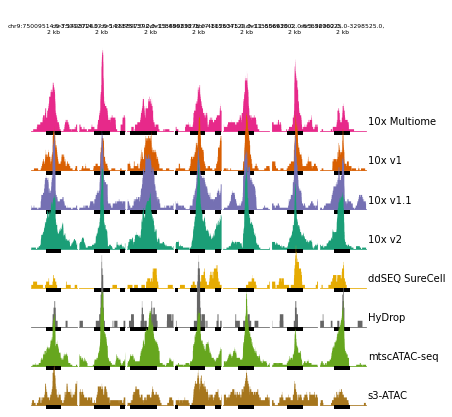

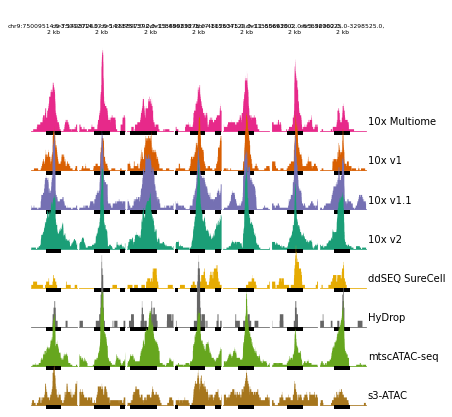

In [26]:
## create the gridspec
fig = plt.figure(figsize=figsize, facecolor="white")

# define ratios between all elements in the graphic
height_ratios = [0.2]  # for gtf
height_ratios.append(len(bw_path_dict))  # for bws
height_ratios.append(0.2)  # for text box

# create a global frame for the 3 modalities shown (bigwigs, gtf, and text)
frame = gridspec.GridSpec(3, 1, wspace=0.25, hspace=0.17, height_ratios=height_ratios)

# create a gridspec for each modality within the frame
n_cols = len(regions_dict)
text_grid = gridspec.GridSpecFromSubplotSpec(
    1, n_cols, wspace=0.05, hspace=0, subplot_spec=frame[0, 0]
)
bw_dar_grid = gridspec.GridSpecFromSubplotSpec(
    len(bw_path_dict), n_cols, wspace=0.05, hspace=-0.6, subplot_spec=frame[1, 0]
)
gtf_grid = gridspec.GridSpecFromSubplotSpec(
    max_genes, n_cols, wspace=0.05, hspace=0, subplot_spec=frame[2, 0]
)

## iterate over all regions (=columns in final figure)
for region_name in regions_df_padded.index:
    if verbose == True:
        print(f"drawing column for region {region_name}")
    region_index = list(regions_df_padded.index).index(
        region_name
    )  # get the region index for column indexing

    # the genome coordinates over which we will be plotting:
    chrom = regions_df_padded.loc[region_name]["chrom"]
    start = int(regions_df_padded.loc[region_name]["start"])
    end = int(regions_df_padded.loc[region_name]["end"])
    x = np.array(range(start, end, 1))

    # set ymax according to region
    # bw_ymax = region_max_dict[region_name]

    # you can also set global ymax:
    bw_ymax = region_max_dict_padded[
        max(region_max_dict_padded, key=region_max_dict_padded.get)
    ]

    ## iterate over all bigwigs (=rows in final figure)
    for key in tech_alias_dict.keys():
        if verbose == True:
            print(f"\t{key}: alias {tech_alias_dict[key]}")

        bw_index = list(tech_alias_dict.keys()).index(
            key
        )  # get the bw index for row indexing

        # create a new gridspec for bw + dar
        if "regions_dict_padded" in locals() or "peak_path_dict" in locals():
            bw_dar_subgrid = gridspec.GridSpecFromSubplotSpec(
                2,
                1,
                wspace=0,
                hspace=0,
                subplot_spec=bw_dar_grid[bw_index, region_index],
                height_ratios=[20, 1],
            )
        else:
            bw_dar_subgrid = gridspec.GridSpecFromSubplotSpec(
                1,
                1,
                wspace=0.05,
                hspace=0.2,
                subplot_spec=bw_dar_grid[bw_index, region_index],
            )

        # open the bigwig
        bw_file = bw_path_dict[key]
        if verbose == True:
            print(f"\t\tbw: {bw_file}")

        bw = pyBigWig.open(bw_file)
        y = bw.values(chrom, start, end)
        y = np.nan_to_num(y)

        # now plot the bigwig in the gridspec
        ax = plt.Subplot(fig, bw_dar_subgrid[0, 0])
        ax.fill_between(
            x, y1=y, y2=0, step="mid", linewidth=0, color=tech_color_palette[key]
        )
        ax.patch.set_alpha(0)

        # figure settings
        ax.set_xlim([x.min(), x.max()])
        ax.set_ylim([0, bw_ymax])
        ax.set_xticks([])
        ax.set_yticks([])

        # add a ylabel only if it's the last column
        if region_name == regions_df_padded.index[-1]:
            ax.yaxis.set_label_position("right")
            ax.set_ylabel(
                tech_alias_dict[key],
                rotation=0,
                horizontalalignment="left",
                verticalalignment="bottom",
            )
            ax.yaxis.set_label_coords(1.05, 0.05)

        sns.despine(top=True, right=True, left=True, bottom=False, ax=ax)
        for spine in ax.spines.values():
            spine.set_edgecolor(tech_color_palette[key])

        # add to the fig
        fig.add_subplot(ax, transparent=True)

        # first draw peaks if they are defined
        if "peak_path_dict" in locals():
            # get peaks that overlap the region to be plotted
            peak = BedTool(peak_path_dict[region_name])
            peak_region_intersection = peak.intersect(
                BedTool.from_dataframe(df=regions_df_padded), wa=True, wb=True
            )
            peak_region_intersection = peak_region_intersection.to_dataframe(
                header=None
            )
            peak_region_intersection = peak_region_intersection.iloc[:, :4]
            peak_region_intersection.columns = "chr start end name".split()

            # now plot the dars in the gridspec
            ax = plt.Subplot(fig, bw_dar_subgrid[1, 0])
            for element in peak_region_intersection.index:
                part = peak_region_intersection.loc[element]
                peak_start = part["start"]
                peak_end = part["end"]

                # plot a thin line, with beginning and ending as x coordinates, and bw_ymin as y coordinates
                # NOTE: linewidth won't do much here, it is more determined by the 'space' you give to this part of the plot in height_ratios!
                ax.plot([peak_start, peak_end], [0, 0], linewidth=4, c=peak_color)

            # figure settings
            ax.set_ylim([-1, +1])
            addax()

        # then draw dars if they are defined
        if "regions_path_dict" in locals():
            # get DARs that overlap the region to be plotted
            dar = BedTool(regions_path_dict[region_name])
            if verbose == True:
                print(f"\t\tdar: {regions_path_dict[region_name]}")

            dar_region_intersection = dar.intersect(
                BedTool.from_dataframe(df=regions_df_padded), wa=True, wb=True
            )
            dar_region_intersection = dar_region_intersection.to_dataframe(header=None)
            dar_region_intersection = dar_region_intersection.iloc[:, :4]
            dar_region_intersection.columns = "chr start end name".split()

            # now plot the dars in the gridspec
            ax = plt.Subplot(fig, bw_dar_subgrid[1, 0])
            for element in dar_region_intersection.index:
                part = dar_region_intersection.loc[element]
                dar_start = part["start"]
                dar_end = part["end"]

                # plot a thin line, with beginning and ending as x coordinates, and bw_ymin as y coordinates
                # NOTE: linewidth won't do much here, it is more determined by the 'space' you give to this part of the plot in height_ratios!
                ax.plot([dar_start, dar_end], [0, 0], linewidth=4, c=dar_color)

            # figure settings
            ax.set_ylim([-1, +1])
            addax()

    ## draw the genes of interest, from our gtf
    # intersect genes gtf with the region of interest
    if plot_genes == True:
        gtf = BedTool(gtf_file)
        gtf_region_intersection = gtf.intersect(
            BedTool.from_dataframe(df=regions_df_padded), wa=True, wb=True
        )
        gtf_region_intersection = gtf_region_intersection.to_dataframe(header=None)
        gtf_region_intersection = gtf_region_intersection.iloc[:, :9]
        gtf_region_intersection.columns = (
            "chr db feature start end score strand frame attribute".split()
        )

        ## iterate over all genes of interest in genes_dict
        for gene in genes_dict[region_name]:
            gene_index = genes_dict[region_name].index(
                gene
            )  # get gene index for row indexing

            # get gtf intersection with only gene body and exons of this particular gene
            gtf_region_intersection_gene = gtf_region_intersection[
                gtf_region_intersection["attribute"].str.contains(gene)
            ]
            gtf_region_intersection_gene = gtf_region_intersection_gene[
                gtf_region_intersection_gene["feature"].str.contains("gene|exon")
            ]

            # now plot the gene parts (gene body and gene exon)
            ax = plt.Subplot(fig, gtf_grid[gene_index, region_index])

            # iterate over all parts to plot them
            for element in gtf_region_intersection_gene.index:
                part = gtf_region_intersection_gene.loc[element]

                # make exons thick
                if part["feature"] == "exon":
                    exon_start = part["start"]
                    exon_end = part["end"]
                    # draw rectangle for exon
                    rect = mpatches.Rectangle(
                        (exon_start, exon_bottom),
                        exon_end - exon_start,
                        exon_height,
                        fill=True,
                        color="k",
                        linewidth=0,
                    )
                    ax.add_patch(rect)

                # make the gene body a thin line, drawn at the end so it will always display on top
                elif part["feature"] == "gene":
                    gene_start = part["start"]
                    gene_end = part["end"]
                    rect = mpatches.Rectangle(
                        (gene_start, gene_bottom),
                        gene_end - gene_start,
                        gene_height,
                        fill=True,
                        color="k",
                        linewidth=0,
                    )
                    ax.add_patch(rect)

        if verbose == True:
            print(
                f"\tfor region {region_name}, drew gene {gene}, {len(gtf_region_intersection_gene.index)} individual items drawn\n"
            )

        # figure settings
        ax.set_ylim([exon_bottom, -exon_bottom])
        ax.set_xlabel(gene, fontsize=10)
        addax()

    ## finally, add a little text that shows which regions you're plotting
    ax = plt.Subplot(fig, text_grid[0, region_index])

    region = regions_dict_padded[region_name]
    length = round((end - start) / 1000)
    label = f"{region},\n{length} kb"

    ax.set_xlabel(label, fontsize=6)
    addax()

fig.savefig(
    "plts_track/libds_track.png",
    dpi=350,
    bbox_inches="tight",
    pad_inches=0,
    transparent=False,
    facecolor="white",
)
fig.savefig(
    "plts_track/libds_track.svg",
    dpi=350,
    bbox_inches="tight",
    pad_inches=0,
    transparent=False,
    facecolor="white",
)

fig

In [27]:
peak_path_dict

{'Cytotoxic_T_cell': 'final_consensus_peaks/master_sub_1.FIXEDCELLS__SCREEN_consensus_peaks.bed',
 'CD14+_monocyte': 'final_consensus_peaks/master_sub_1.FIXEDCELLS__SCREEN_consensus_peaks.bed',
 'B_cell': 'final_consensus_peaks/master_sub_1.FIXEDCELLS__SCREEN_consensus_peaks.bed',
 'CD16+_monocyte': 'final_consensus_peaks/master_sub_1.FIXEDCELLS__SCREEN_consensus_peaks.bed',
 'Dendritic_cell': 'final_consensus_peaks/master_sub_1.FIXEDCELLS__SCREEN_consensus_peaks.bed',
 'Natural_killer_cell': 'final_consensus_peaks/master_sub_1.FIXEDCELLS__SCREEN_consensus_peaks.bed',
 'CD4+_T_cell': 'final_consensus_peaks/master_sub_1.FIXEDCELLS__SCREEN_consensus_peaks.bed'}

# now make cell-type specific, using tech-cell_type BWs

In [28]:
cell_types = list(
    set(
        [
            "_".join(x.split("/")[-1].split("_")[1:]).split(".")[0]
            for x in glob.glob(
                "per_tech_cell_type_bigwigs/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/*"
            )
        ]
    )
)

bw_path_dict_dict = {}
for cell_type in cell_types:
    # print(cell_type)
    bw_path_dict_dict[cell_type] = {
        x.split("/")[-1].split("_")[0]: x
        for x in glob.glob(
            f"per_tech_cell_type_bigwigs/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/*{cell_type}*"
        )
    }
bw_path_dict_dict

{'CD14_monocyte': {'10xv2': 'per_tech_cell_type_bigwigs/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/10xv2_CD14_monocyte.bw',
  'hydrop': 'per_tech_cell_type_bigwigs/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/hydrop_CD14_monocyte.bw',
  '10xmultiome': 'per_tech_cell_type_bigwigs/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/10xmultiome_CD14_monocyte.bw',
  'ddseq': 'per_tech_cell_type_bigwigs/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/ddseq_CD14_monocyte.bw',
  'mtscatac': 'per_tech_cell_type_bigwigs/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/mtscatac_CD14_monocyte.bw',
  's3atac': 'per_tech_cell_type_bigwigs/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/s3atac_CD14_monocyte.bw',
  '10xv11': 'per_tech_cell_type_bigwigs/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/10xv11_CD14_monocyte.bw',
  '10xv1': 'per_tech_cell_type_bigwigs/master_sub_1.FIXEDCELLS__CONSEN

In [29]:
dar_color = "b"
peak_color = "k"
gene_height = 3
gene_bottom = -gene_height / 2
exon_height = 6
exon_bottom = -exon_height / 2

figsize = (6, 8)

In [30]:
def addax():
    ax.set_xlim([x.min(), x.max()])
    sns.despine(top=True, right=True, left=True, bottom=True, ax=ax)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.patch.set_alpha(
        0
    )  # make sure that each individual subplot is transparent! otherwise the underlying plots won't be shown. this is important e.g. for the dar/peak visualisaton, since the DARs are drawn directly on top of the peaks. if the DAR plot is not transparent, no peaks will be visible!!

    fig.add_subplot(ax)

In [31]:
max_genes = 1

In [32]:
plot_genes = False
verbose = True

In [33]:
region_forced_length = 2000

regions_df_padded = regions_df.copy()

regions_df_padded["region_center"] = (
    regions_df_padded["start"]
    + (regions_df_padded["end"] - regions_df_padded["start"]) / 2
)


regions_df_padded["start"] = (
    regions_df_padded["region_center"] - region_forced_length / 2
)
regions_df_padded["start"] = [int(x) for x in regions_df_padded["start"]]
regions_df_padded["end"] = regions_df_padded["region_center"] + region_forced_length / 2
regions_df_padded["end"] = [int(x) for x in regions_df_padded["end"]]

In [34]:
## calculate bw_ymax per col
region_max_dict_padded = {}
for region_name in regions_df_padded.index:
    chrom = regions_df_padded.loc[region_name]["chrom"]
    start = int(regions_df_padded.loc[region_name]["start"])
    end = int(regions_df_padded.loc[region_name]["end"])

    bw_ymax_dict_dict = {}
    for cell_type in bw_path_dict_dict.keys():
        bw_ymax_dict = {}

        for tech in bw_path_dict_dict[cell_type].keys():
            bw_file = bw_path_dict_dict[cell_type][tech]

            # calculate max value of the bigwig within our region
            bw = pyBigWig.open(bw_file)
            y = bw.values(chrom, start, end)
            y = np.nan_to_num(y)

            bw_ymax_dict[tech] = y.max()

        bw_ymax_dict_dict[cell_type] = max(bw_ymax_dict.values())

    region_max_dict_padded[region_name] = bw_ymax_dict_dict[
        max(bw_ymax_dict_dict, key=bw_ymax_dict_dict.get)
    ]
    print(f"calculated max values within region {region_name}")

region_max_dict_padded

calculated max values within region Cytotoxic_T_cell
calculated max values within region CD14+_monocyte
calculated max values within region B_cell
calculated max values within region CD16+_monocyte
calculated max values within region Dendritic_cell
calculated max values within region Natural_killer_cell
calculated max values within region CD4+_T_cell


{'Cytotoxic_T_cell': 2.3661723136901855,
 'CD14+_monocyte': 2.5766940116882324,
 'B_cell': 15.218615531921387,
 'CD16+_monocyte': 6.3200907707214355,
 'Dendritic_cell': 3.3550257682800293,
 'Natural_killer_cell': 5.081324100494385,
 'CD4+_T_cell': 2.3617825508117676}

In [35]:
regions_df_padded

,chrom,start,end,region_center
Cytotoxic_T_cell,chr9,75009764,75011764,75010764.0
CD14+_monocyte,chr3,149372887,149374887,149373887.0
B_cell,chr5,158897642,158899642,158898642.0
CD16+_monocyte,chr13,48624125,48626125,48625125.0
Dendritic_cell,chr7,115504370,115506370,115505370.0
Natural_killer_cell,chr11,65694052,65696052,65695052.0
CD4+_T_cell,chr3,3296275,3298275,3297275.0


In [36]:
regions_dict_padded = OrderedDict({})

for supersample, path in merged_dar_path_dict.items():
    # print(supersample)
    df = pd.read_csv(path, sep="\t", header=None)
    df.columns = "chrom start end cell_type log2fc strand p_val".split()
    # print(df.iloc[0])

    cell_type = supersample.split("__")[-1].replace("+", "")
    region = f"{df.iloc[0]['chrom']}:{df.iloc[0]['start']- region_forced_length / 2}-{df.iloc[0]['end']+region_forced_length / 2}"
    regions_dict_padded[cell_type] = region

regions_dict_padded

OrderedDict([('Cytotoxic_T_cell', 'chr9:75009514.0-75012014.0'),
             ('CD14_monocyte', 'chr3:149372637.0-149375137.0'),
             ('B_cell', 'chr5:158897392.0-158899892.0'),
             ('CD16_monocyte', 'chr13:48623875.0-48626375.0'),
             ('Dendritic_cell', 'chr7:115504120.0-115506620.0'),
             ('Natural_killer_cell', 'chr11:65693802.0-65696302.0'),
             ('CD4_T_cell', 'chr3:3296025.0-3298525.0')])

In [37]:
bw_path_dict_dict.keys()

dict_keys(['CD14_monocyte', 'Dendritic_cell', 'CD16_monocyte', 'CD4_T_cell', 'B_cell', 'Natural_killer_cell', 'Cytotoxic_T_cell'])

In [38]:
regions_df_padded.index = [x.replace("+", "") for x in regions_df_padded.index]

In [39]:
peak_path_dict = {
    x.replace(
        "+", ""
    ): "final_consensus_peaks/master_sub_1.FIXEDCELLS__SCREEN_consensus_peaks.bed"
    for x in regions_dict.keys()
}
peak_path_dict

{'Cytotoxic_T_cell': 'final_consensus_peaks/master_sub_1.FIXEDCELLS__SCREEN_consensus_peaks.bed',
 'CD14_monocyte': 'final_consensus_peaks/master_sub_1.FIXEDCELLS__SCREEN_consensus_peaks.bed',
 'B_cell': 'final_consensus_peaks/master_sub_1.FIXEDCELLS__SCREEN_consensus_peaks.bed',
 'CD16_monocyte': 'final_consensus_peaks/master_sub_1.FIXEDCELLS__SCREEN_consensus_peaks.bed',
 'Dendritic_cell': 'final_consensus_peaks/master_sub_1.FIXEDCELLS__SCREEN_consensus_peaks.bed',
 'Natural_killer_cell': 'final_consensus_peaks/master_sub_1.FIXEDCELLS__SCREEN_consensus_peaks.bed',
 'CD4_T_cell': 'final_consensus_peaks/master_sub_1.FIXEDCELLS__SCREEN_consensus_peaks.bed'}

In [40]:
set(regions_df_padded.index) == set(regions_dict_padded.keys()) == set(
    bw_path_dict_dict.keys()
) == set(peak_path_dict.keys())

True

drawing column for region Cytotoxic_T_cell
	10xv1: alias 10x v1
		bw: per_tech_cell_type_bigwigs/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/10xv1_Cytotoxic_T_cell.bw
	ddseq: alias ddSEQ SureCell
		bw: per_tech_cell_type_bigwigs/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/ddseq_Cytotoxic_T_cell.bw
	s3atac: alias s3-ATAC
		bw: per_tech_cell_type_bigwigs/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/s3atac_Cytotoxic_T_cell.bw
	mtscatac: alias mtscATAC-seq
		bw: per_tech_cell_type_bigwigs/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/mtscatac_Cytotoxic_T_cell.bw
	10xv2: alias 10x v2
		bw: per_tech_cell_type_bigwigs/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/10xv2_Cytotoxic_T_cell.bw
	10xmultiome: alias 10x Multiome
		bw: per_tech_cell_type_bigwigs/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/10xmultiome_Cytotoxic_T_cell.bw
	hydrop: alias HyDrop
		bw: per_tech_cell_type_bigwigs/mas

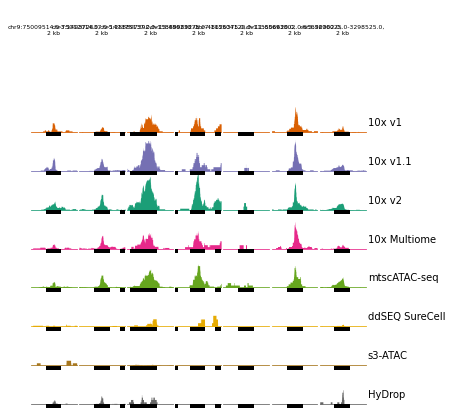

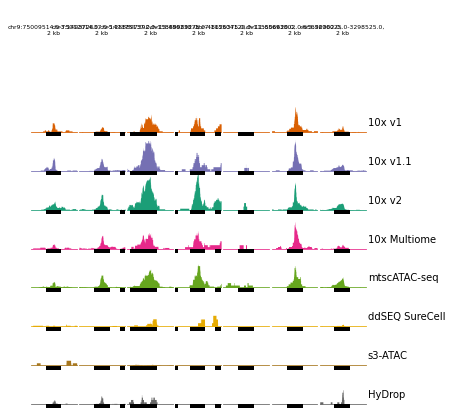

In [42]:
## create the gridspec
fig = plt.figure(figsize=figsize, facecolor="white")

# define ratios between all elements in the graphic
height_ratios = [0.2]  # for gtf
height_ratios.append(len(bw_path_dict_dict))  # for bws
height_ratios.append(0.2)  # for text box

# create a global frame for the 3 modalities shown (bigwigs, gtf, and text)
frame = gridspec.GridSpec(3, 1, wspace=0.25, hspace=0.17, height_ratios=height_ratios)

# create a gridspec for each modality within the frame
n_cols = len(regions_dict)
n_rows = len(tech_order)

text_grid = gridspec.GridSpecFromSubplotSpec(
    1, n_cols, wspace=0.05, hspace=0, subplot_spec=frame[0, 0]
)
bw_dar_grid = gridspec.GridSpecFromSubplotSpec(
    n_rows, n_cols, wspace=0.05, hspace=-0.6, subplot_spec=frame[1, 0]
)
gtf_grid = gridspec.GridSpecFromSubplotSpec(
    max_genes, n_cols, wspace=0.05, hspace=0, subplot_spec=frame[2, 0]
)

## iterate over all regions (=columns in final figure)
for region_name in regions_df_padded.index:
    if verbose == True:
        print(f"drawing column for region {region_name}")
    region_index = list(regions_df_padded.index).index(
        region_name
    )  # get the region index for column indexing

    # the genome coordinates over which we will be plotting:
    chrom = regions_df_padded.loc[region_name]["chrom"]
    start = int(regions_df_padded.loc[region_name]["start"])
    end = int(regions_df_padded.loc[region_name]["end"])
    x = np.array(range(start, end, 1))

    # set ymax according to region
    # bw_ymax = region_max_dict[region_name]

    # you can also set global ymax:
    bw_ymax = region_max_dict_padded[
        max(region_max_dict_padded, key=region_max_dict_padded.get)
    ]

    ## iterate over all bigwigs (=rows in final figure)
    for key in bw_path_dict_dict[region_name].keys():
        if verbose == True:
            print(f"\t{key}: alias {tech_alias_dict[key]}")

        bw_index = tech_order.index(key)  # get the bw index for row indexing

        # create a new gridspec for bw + dar
        if "regions_dict_padded" in locals() or "peak_path_dict" in locals():
            bw_dar_subgrid = gridspec.GridSpecFromSubplotSpec(
                2,
                1,
                wspace=0,
                hspace=0,
                subplot_spec=bw_dar_grid[bw_index, region_index],
                height_ratios=[20, 1],
            )
        else:
            bw_dar_subgrid = gridspec.GridSpecFromSubplotSpec(
                1,
                1,
                wspace=0.05,
                hspace=0.2,
                subplot_spec=bw_dar_grid[bw_index, region_index],
            )

        # open the bigwig
        bw_file = bw_path_dict_dict[region_name][key]
        if verbose == True:
            print(f"\t\tbw: {bw_file}")

        bw = pyBigWig.open(bw_file)
        y = bw.values(chrom, start, end)
        y = np.nan_to_num(y)

        # now plot the bigwig in the gridspec
        ax = plt.Subplot(fig, bw_dar_subgrid[0, 0])
        ax.fill_between(
            x, y1=y, y2=0, step="mid", linewidth=0, color=tech_color_palette[key]
        )
        ax.patch.set_alpha(0)

        # figure settings
        ax.set_xlim([x.min(), x.max()])
        ax.set_ylim([0, bw_ymax])
        ax.set_xticks([])
        ax.set_yticks([])

        # add a ylabel only if it's the last column
        if region_name == regions_df_padded.index[-1]:
            ax.yaxis.set_label_position("right")
            ax.set_ylabel(
                tech_alias_dict[key],
                rotation=0,
                horizontalalignment="left",
                verticalalignment="bottom",
            )
            ax.yaxis.set_label_coords(1.05, 0.05)

        sns.despine(top=True, right=True, left=True, bottom=False, ax=ax)
        for spine in ax.spines.values():
            spine.set_edgecolor(tech_color_palette[key])

        # add to the fig
        fig.add_subplot(ax, transparent=True)

        # first draw peaks if they are defined
        if "peak_path_dict" in locals():
            # get peaks that overlap the region to be plotted
            peak = BedTool(peak_path_dict[region_name])
            peak_region_intersection = peak.intersect(
                BedTool.from_dataframe(df=regions_df_padded), wa=True, wb=True
            )
            peak_region_intersection = peak_region_intersection.to_dataframe(
                header=None
            )
            peak_region_intersection = peak_region_intersection.iloc[:, :4]
            peak_region_intersection.columns = "chr start end name".split()

            # now plot the dars in the gridspec
            ax = plt.Subplot(fig, bw_dar_subgrid[1, 0])
            for element in peak_region_intersection.index:
                part = peak_region_intersection.loc[element]
                peak_start = part["start"]
                peak_end = part["end"]

                # plot a thin line, with beginning and ending as x coordinates, and bw_ymin as y coordinates
                # NOTE: linewidth won't do much here, it is more determined by the 'space' you give to this part of the plot in height_ratios!
                ax.plot([peak_start, peak_end], [0, 0], linewidth=4, c=peak_color)

            # figure settings
            ax.set_ylim([-1, +1])
            addax()

        # then draw dars if they are defined
        if "regions_path_dict" in locals():
            # get DARs that overlap the region to be plotted
            dar = BedTool(regions_path_dict[region_name])
            if verbose == True:
                print(f"\t\tdar: {regions_path_dict[region_name]}")

            dar_region_intersection = dar.intersect(
                BedTool.from_dataframe(df=regions_df_padded), wa=True, wb=True
            )
            dar_region_intersection = dar_region_intersection.to_dataframe(header=None)
            dar_region_intersection = dar_region_intersection.iloc[:, :4]
            dar_region_intersection.columns = "chr start end name".split()

            # now plot the dars in the gridspec
            ax = plt.Subplot(fig, bw_dar_subgrid[1, 0])
            for element in dar_region_intersection.index:
                part = dar_region_intersection.loc[element]
                dar_start = part["start"]
                dar_end = part["end"]

                # plot a thin line, with beginning and ending as x coordinates, and bw_ymin as y coordinates
                # NOTE: linewidth won't do much here, it is more determined by the 'space' you give to this part of the plot in height_ratios!
                ax.plot([dar_start, dar_end], [0, 0], linewidth=4, c=dar_color)

            # figure settings
            ax.set_ylim([-1, +1])
            addax()

    ## draw the genes of interest, from our gtf
    # intersect genes gtf with the region of interest
    if plot_genes == True:
        gtf = BedTool(gtf_file)
        gtf_region_intersection = gtf.intersect(
            BedTool.from_dataframe(df=regions_df_padded), wa=True, wb=True
        )
        gtf_region_intersection = gtf_region_intersection.to_dataframe(header=None)
        gtf_region_intersection = gtf_region_intersection.iloc[:, :9]
        gtf_region_intersection.columns = (
            "chr db feature start end score strand frame attribute".split()
        )

        ## iterate over all genes of interest in genes_dict
        for gene in genes_dict[region_name]:
            gene_index = genes_dict[region_name].index(
                gene
            )  # get gene index for row indexing

            # get gtf intersection with only gene body and exons of this particular gene
            gtf_region_intersection_gene = gtf_region_intersection[
                gtf_region_intersection["attribute"].str.contains(gene)
            ]
            gtf_region_intersection_gene = gtf_region_intersection_gene[
                gtf_region_intersection_gene["feature"].str.contains("gene|exon")
            ]

            # now plot the gene parts (gene body and gene exon)
            ax = plt.Subplot(fig, gtf_grid[gene_index, region_index])

            # iterate over all parts to plot them
            for element in gtf_region_intersection_gene.index:
                part = gtf_region_intersection_gene.loc[element]

                # make exons thick
                if part["feature"] == "exon":
                    exon_start = part["start"]
                    exon_end = part["end"]
                    # draw rectangle for exon
                    rect = mpatches.Rectangle(
                        (exon_start, exon_bottom),
                        exon_end - exon_start,
                        exon_height,
                        fill=True,
                        color="k",
                        linewidth=0,
                    )
                    ax.add_patch(rect)

                # make the gene body a thin line, drawn at the end so it will always display on top
                elif part["feature"] == "gene":
                    gene_start = part["start"]
                    gene_end = part["end"]
                    rect = mpatches.Rectangle(
                        (gene_start, gene_bottom),
                        gene_end - gene_start,
                        gene_height,
                        fill=True,
                        color="k",
                        linewidth=0,
                    )
                    ax.add_patch(rect)

        if verbose == True:
            print(
                f"\tfor region {region_name}, drew gene {gene}, {len(gtf_region_intersection_gene.index)} individual items drawn\n"
            )

        # figure settings
        ax.set_ylim([exon_bottom, -exon_bottom])
        ax.set_xlabel(gene, fontsize=10)
        addax()

    ## finally, add a little text that shows which regions you're plotting
    ax = plt.Subplot(fig, text_grid[0, region_index])

    region = regions_dict_padded[region_name]
    length = round((end - start) / 1000)
    label = f"{region},\n{length} kb"

    ax.set_xlabel(label, fontsize=6)
    addax()

fig.savefig(
    "plts_track/libds_track.png",
    dpi=350,
    bbox_inches="tight",
    pad_inches=0,
    transparent=False,
    facecolor="white",
)
fig.savefig(
    "plts_track/libds_track.svg",
    dpi=350,
    bbox_inches="tight",
    pad_inches=0,
    transparent=False,
    facecolor="white",
)

fig

# now same but without normalisation

In [43]:
cell_types = list(
    set(
        [
            "_".join(x.split("/")[-1].split("_")[1:]).split(".")[0]
            for x in glob.glob(
                "per_tech_cell_type_bigwigs_nonnorm/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/*"
            )
        ]
    )
)

bw_path_dict_dict = {}
for cell_type in cell_types:
    # print(cell_type)
    bw_path_dict_dict[cell_type] = {
        x.split("/")[-1].split("_")[0]: x
        for x in glob.glob(
            f"per_tech_cell_type_bigwigs_nonnorm/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/*{cell_type}*"
        )
    }
bw_path_dict_dict

{'CD14_monocyte': {'10xv2': 'per_tech_cell_type_bigwigs_nonnorm/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/10xv2_CD14_monocyte.bw',
  'hydrop': 'per_tech_cell_type_bigwigs_nonnorm/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/hydrop_CD14_monocyte.bw',
  '10xmultiome': 'per_tech_cell_type_bigwigs_nonnorm/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/10xmultiome_CD14_monocyte.bw',
  'ddseq': 'per_tech_cell_type_bigwigs_nonnorm/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/ddseq_CD14_monocyte.bw',
  'mtscatac': 'per_tech_cell_type_bigwigs_nonnorm/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/mtscatac_CD14_monocyte.bw',
  's3atac': 'per_tech_cell_type_bigwigs_nonnorm/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/s3atac_CD14_monocyte.bw',
  '10xv11': 'per_tech_cell_type_bigwigs_nonnorm/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/10xv11_CD14_monocyte.bw',
  '10xv1': 'pe

In [44]:
dar_color = "b"
peak_color = "k"
gene_height = 3
gene_bottom = -gene_height / 2
exon_height = 6
exon_bottom = -exon_height / 2

figsize = (6, 8)

In [45]:
def addax():
    ax.set_xlim([x.min(), x.max()])
    sns.despine(top=True, right=True, left=True, bottom=True, ax=ax)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.patch.set_alpha(
        0
    )  # make sure that each individual subplot is transparent! otherwise the underlying plots won't be shown. this is important e.g. for the dar/peak visualisaton, since the DARs are drawn directly on top of the peaks. if the DAR plot is not transparent, no peaks will be visible!!

    fig.add_subplot(ax)

In [46]:
max_genes = 1

In [47]:
plot_genes = False
verbose = True

In [48]:
region_forced_length = 2000

regions_df_padded = regions_df.copy()

regions_df_padded["region_center"] = (
    regions_df_padded["start"]
    + (regions_df_padded["end"] - regions_df_padded["start"]) / 2
)


regions_df_padded["start"] = (
    regions_df_padded["region_center"] - region_forced_length / 2
)
regions_df_padded["start"] = [int(x) for x in regions_df_padded["start"]]
regions_df_padded["end"] = regions_df_padded["region_center"] + region_forced_length / 2
regions_df_padded["end"] = [int(x) for x in regions_df_padded["end"]]

In [49]:
## calculate bw_ymax per col
region_max_dict_padded = {}
for region_name in regions_df_padded.index:
    chrom = regions_df_padded.loc[region_name]["chrom"]
    start = int(regions_df_padded.loc[region_name]["start"])
    end = int(regions_df_padded.loc[region_name]["end"])

    bw_ymax_dict_dict = {}
    for cell_type in bw_path_dict_dict.keys():
        bw_ymax_dict = {}

        for tech in bw_path_dict_dict[cell_type].keys():
            bw_file = bw_path_dict_dict[cell_type][tech]

            # calculate max value of the bigwig within our region
            bw = pyBigWig.open(bw_file)
            y = bw.values(chrom, start, end)
            y = np.nan_to_num(y)

            bw_ymax_dict[tech] = y.max()

        bw_ymax_dict_dict[cell_type] = max(bw_ymax_dict.values())

    region_max_dict_padded[region_name] = bw_ymax_dict_dict[
        max(bw_ymax_dict_dict, key=bw_ymax_dict_dict.get)
    ]
    print(f"calculated max values within region {region_name}")

region_max_dict_padded

calculated max values within region Cytotoxic_T_cell
calculated max values within region CD14+_monocyte
calculated max values within region B_cell
calculated max values within region CD16+_monocyte
calculated max values within region Dendritic_cell
calculated max values within region Natural_killer_cell
calculated max values within region CD4+_T_cell


{'Cytotoxic_T_cell': 24.0,
 'CD14+_monocyte': 56.0,
 'B_cell': 38.0,
 'CD16+_monocyte': 37.0,
 'Dendritic_cell': 40.0,
 'Natural_killer_cell': 39.0,
 'CD4+_T_cell': 36.0}

In [50]:
regions_df_padded

,chrom,start,end,region_center
Cytotoxic_T_cell,chr9,75009764,75011764,75010764.0
CD14+_monocyte,chr3,149372887,149374887,149373887.0
B_cell,chr5,158897642,158899642,158898642.0
CD16+_monocyte,chr13,48624125,48626125,48625125.0
Dendritic_cell,chr7,115504370,115506370,115505370.0
Natural_killer_cell,chr11,65694052,65696052,65695052.0
CD4+_T_cell,chr3,3296275,3298275,3297275.0


In [51]:
regions_dict_padded = OrderedDict({})

for supersample, path in merged_dar_path_dict.items():
    # print(supersample)
    df = pd.read_csv(path, sep="\t", header=None)
    df.columns = "chrom start end cell_type log2fc strand p_val".split()
    # print(df.iloc[0])

    cell_type = supersample.split("__")[-1].replace("+", "")
    region = f"{df.iloc[0]['chrom']}:{df.iloc[0]['start']- region_forced_length / 2}-{df.iloc[0]['end']+region_forced_length / 2}"
    regions_dict_padded[cell_type] = region

regions_dict_padded

OrderedDict([('Cytotoxic_T_cell', 'chr9:75009514.0-75012014.0'),
             ('CD14_monocyte', 'chr3:149372637.0-149375137.0'),
             ('B_cell', 'chr5:158897392.0-158899892.0'),
             ('CD16_monocyte', 'chr13:48623875.0-48626375.0'),
             ('Dendritic_cell', 'chr7:115504120.0-115506620.0'),
             ('Natural_killer_cell', 'chr11:65693802.0-65696302.0'),
             ('CD4_T_cell', 'chr3:3296025.0-3298525.0')])

In [52]:
bw_path_dict_dict.keys()

dict_keys(['CD14_monocyte', 'Dendritic_cell', 'CD16_monocyte', 'CD4_T_cell', 'B_cell', 'Natural_killer_cell', 'Cytotoxic_T_cell'])

In [53]:
regions_df_padded.index = [x.replace("+", "") for x in regions_df_padded.index]

In [54]:
peak_path_dict = {
    x.replace(
        "+", ""
    ): "final_consensus_peaks/master_sub_1.FIXEDCELLS__SCREEN_consensus_peaks.bed"
    for x in regions_dict.keys()
}
peak_path_dict

{'Cytotoxic_T_cell': 'final_consensus_peaks/master_sub_1.FIXEDCELLS__SCREEN_consensus_peaks.bed',
 'CD14_monocyte': 'final_consensus_peaks/master_sub_1.FIXEDCELLS__SCREEN_consensus_peaks.bed',
 'B_cell': 'final_consensus_peaks/master_sub_1.FIXEDCELLS__SCREEN_consensus_peaks.bed',
 'CD16_monocyte': 'final_consensus_peaks/master_sub_1.FIXEDCELLS__SCREEN_consensus_peaks.bed',
 'Dendritic_cell': 'final_consensus_peaks/master_sub_1.FIXEDCELLS__SCREEN_consensus_peaks.bed',
 'Natural_killer_cell': 'final_consensus_peaks/master_sub_1.FIXEDCELLS__SCREEN_consensus_peaks.bed',
 'CD4_T_cell': 'final_consensus_peaks/master_sub_1.FIXEDCELLS__SCREEN_consensus_peaks.bed'}

In [55]:
set(regions_df_padded.index) == set(regions_dict_padded.keys()) == set(
    bw_path_dict_dict.keys()
) == set(peak_path_dict.keys())

True

In [56]:
n_rows

8

drawing column for region Cytotoxic_T_cell
	10xv1: alias 10x v1
		bw: per_tech_cell_type_bigwigs_nonnorm/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/10xv1_Cytotoxic_T_cell.bw
	ddseq: alias ddSEQ SureCell
		bw: per_tech_cell_type_bigwigs_nonnorm/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/ddseq_Cytotoxic_T_cell.bw
	s3atac: alias s3-ATAC
		bw: per_tech_cell_type_bigwigs_nonnorm/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/s3atac_Cytotoxic_T_cell.bw
	mtscatac: alias mtscATAC-seq
		bw: per_tech_cell_type_bigwigs_nonnorm/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/mtscatac_Cytotoxic_T_cell.bw
	10xv2: alias 10x v2
		bw: per_tech_cell_type_bigwigs_nonnorm/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/10xv2_Cytotoxic_T_cell.bw
	10xmultiome: alias 10x Multiome
		bw: per_tech_cell_type_bigwigs_nonnorm/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/10xmultiome_Cytotoxic_T_cell.bw
	hydrop: a

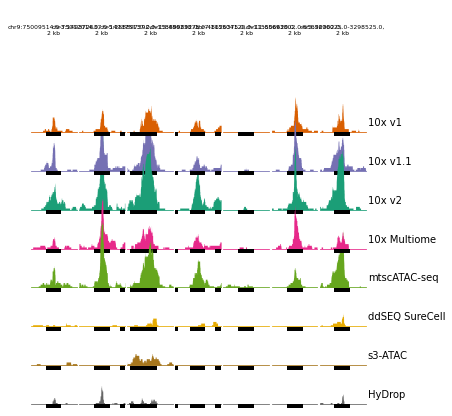

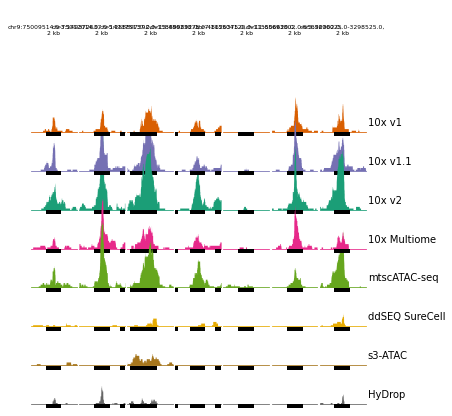

In [57]:
## create the gridspec
fig = plt.figure(figsize=figsize, facecolor="white")

# define ratios between all elements in the graphic
height_ratios = [0.2]  # for gtf
height_ratios.append(len(bw_path_dict_dict))  # for bws
height_ratios.append(0.2)  # for text box

# create a global frame for the 3 modalities shown (bigwigs, gtf, and text)
frame = gridspec.GridSpec(3, 1, wspace=0.25, hspace=0.17, height_ratios=height_ratios)

# create a gridspec for each modality within the frame
n_cols = len(regions_dict)
n_rows = len(tech_order)

text_grid = gridspec.GridSpecFromSubplotSpec(
    1, n_cols, wspace=0.05, hspace=0, subplot_spec=frame[0, 0]
)
bw_dar_grid = gridspec.GridSpecFromSubplotSpec(
    n_rows, n_cols, wspace=0.05, hspace=-0.6, subplot_spec=frame[1, 0]
)
gtf_grid = gridspec.GridSpecFromSubplotSpec(
    max_genes, n_cols, wspace=0.05, hspace=0, subplot_spec=frame[2, 0]
)

## iterate over all regions (=columns in final figure)
for region_name in regions_df_padded.index:
    if verbose == True:
        print(f"drawing column for region {region_name}")
    region_index = list(regions_df_padded.index).index(
        region_name
    )  # get the region index for column indexing

    # the genome coordinates over which we will be plotting:
    chrom = regions_df_padded.loc[region_name]["chrom"]
    start = int(regions_df_padded.loc[region_name]["start"])
    end = int(regions_df_padded.loc[region_name]["end"])
    x = np.array(range(start, end, 1))

    # set ymax according to region
    # bw_ymax = region_max_dict[region_name]

    # you can also set global ymax:
    bw_ymax = region_max_dict_padded[
        max(region_max_dict_padded, key=region_max_dict_padded.get)
    ]

    ## iterate over all bigwigs (=rows in final figure)
    for key in bw_path_dict_dict[region_name].keys():
        if verbose == True:
            print(f"\t{key}: alias {tech_alias_dict[key]}")

        bw_index = tech_order.index(key)  # get the bw index for row indexing

        # create a new gridspec for bw + dar
        if "regions_dict_padded" in locals() or "peak_path_dict" in locals():
            bw_dar_subgrid = gridspec.GridSpecFromSubplotSpec(
                2,
                1,
                wspace=0,
                hspace=0,
                subplot_spec=bw_dar_grid[bw_index, region_index],
                height_ratios=[20, 1],
            )
        else:
            bw_dar_subgrid = gridspec.GridSpecFromSubplotSpec(
                1,
                1,
                wspace=0.05,
                hspace=0.2,
                subplot_spec=bw_dar_grid[bw_index, region_index],
            )

        # open the bigwig
        bw_file = bw_path_dict_dict[region_name][key]
        if verbose == True:
            print(f"\t\tbw: {bw_file}")

        bw = pyBigWig.open(bw_file)
        y = bw.values(chrom, start, end)
        y = np.nan_to_num(y)

        # now plot the bigwig in the gridspec
        ax = plt.Subplot(fig, bw_dar_subgrid[0, 0])
        ax.fill_between(
            x, y1=y, y2=0, step="mid", linewidth=0, color=tech_color_palette[key]
        )
        ax.patch.set_alpha(0)

        # figure settings
        ax.set_xlim([x.min(), x.max()])
        ax.set_ylim([0, bw_ymax])
        ax.set_xticks([])
        ax.set_yticks([])

        # add a ylabel only if it's the last column
        if region_name == regions_df_padded.index[-1]:
            ax.yaxis.set_label_position("right")
            ax.set_ylabel(
                tech_alias_dict[key],
                rotation=0,
                horizontalalignment="left",
                verticalalignment="bottom",
            )
            ax.yaxis.set_label_coords(1.05, 0.05)

        sns.despine(top=True, right=True, left=True, bottom=False, ax=ax)
        for spine in ax.spines.values():
            spine.set_edgecolor(tech_color_palette[key])

        # add to the fig
        fig.add_subplot(ax, transparent=True)

        # first draw peaks if they are defined
        if "peak_path_dict" in locals():
            # get peaks that overlap the region to be plotted
            peak = BedTool(peak_path_dict[region_name])
            peak_region_intersection = peak.intersect(
                BedTool.from_dataframe(df=regions_df_padded), wa=True, wb=True
            )
            peak_region_intersection = peak_region_intersection.to_dataframe(
                header=None
            )
            peak_region_intersection = peak_region_intersection.iloc[:, :4]
            peak_region_intersection.columns = "chr start end name".split()

            # now plot the dars in the gridspec
            ax = plt.Subplot(fig, bw_dar_subgrid[1, 0])
            for element in peak_region_intersection.index:
                part = peak_region_intersection.loc[element]
                peak_start = part["start"]
                peak_end = part["end"]

                # plot a thin line, with beginning and ending as x coordinates, and bw_ymin as y coordinates
                # NOTE: linewidth won't do much here, it is more determined by the 'space' you give to this part of the plot in height_ratios!
                ax.plot([peak_start, peak_end], [0, 0], linewidth=4, c=peak_color)

            # figure settings
            ax.set_ylim([-1, +1])
            addax()

        # then draw dars if they are defined
        if "regions_path_dict" in locals():
            # get DARs that overlap the region to be plotted
            dar = BedTool(regions_path_dict[region_name])
            if verbose == True:
                print(f"\t\tdar: {regions_path_dict[region_name]}")

            dar_region_intersection = dar.intersect(
                BedTool.from_dataframe(df=regions_df_padded), wa=True, wb=True
            )
            dar_region_intersection = dar_region_intersection.to_dataframe(header=None)
            dar_region_intersection = dar_region_intersection.iloc[:, :4]
            dar_region_intersection.columns = "chr start end name".split()

            # now plot the dars in the gridspec
            ax = plt.Subplot(fig, bw_dar_subgrid[1, 0])
            for element in dar_region_intersection.index:
                part = dar_region_intersection.loc[element]
                dar_start = part["start"]
                dar_end = part["end"]

                # plot a thin line, with beginning and ending as x coordinates, and bw_ymin as y coordinates
                # NOTE: linewidth won't do much here, it is more determined by the 'space' you give to this part of the plot in height_ratios!
                ax.plot([dar_start, dar_end], [0, 0], linewidth=4, c=dar_color)

            # figure settings
            ax.set_ylim([-1, +1])
            addax()

    ## draw the genes of interest, from our gtf
    # intersect genes gtf with the region of interest
    if plot_genes == True:
        gtf = BedTool(gtf_file)
        gtf_region_intersection = gtf.intersect(
            BedTool.from_dataframe(df=regions_df_padded), wa=True, wb=True
        )
        gtf_region_intersection = gtf_region_intersection.to_dataframe(header=None)
        gtf_region_intersection = gtf_region_intersection.iloc[:, :9]
        gtf_region_intersection.columns = (
            "chr db feature start end score strand frame attribute".split()
        )

        ## iterate over all genes of interest in genes_dict
        for gene in genes_dict[region_name]:
            gene_index = genes_dict[region_name].index(
                gene
            )  # get gene index for row indexing

            # get gtf intersection with only gene body and exons of this particular gene
            gtf_region_intersection_gene = gtf_region_intersection[
                gtf_region_intersection["attribute"].str.contains(gene)
            ]
            gtf_region_intersection_gene = gtf_region_intersection_gene[
                gtf_region_intersection_gene["feature"].str.contains("gene|exon")
            ]

            # now plot the gene parts (gene body and gene exon)
            ax = plt.Subplot(fig, gtf_grid[gene_index, region_index])

            # iterate over all parts to plot them
            for element in gtf_region_intersection_gene.index:
                part = gtf_region_intersection_gene.loc[element]

                # make exons thick
                if part["feature"] == "exon":
                    exon_start = part["start"]
                    exon_end = part["end"]
                    # draw rectangle for exon
                    rect = mpatches.Rectangle(
                        (exon_start, exon_bottom),
                        exon_end - exon_start,
                        exon_height,
                        fill=True,
                        color="k",
                        linewidth=0,
                    )
                    ax.add_patch(rect)

                # make the gene body a thin line, drawn at the end so it will always display on top
                elif part["feature"] == "gene":
                    gene_start = part["start"]
                    gene_end = part["end"]
                    rect = mpatches.Rectangle(
                        (gene_start, gene_bottom),
                        gene_end - gene_start,
                        gene_height,
                        fill=True,
                        color="k",
                        linewidth=0,
                    )
                    ax.add_patch(rect)

        if verbose == True:
            print(
                f"\tfor region {region_name}, drew gene {gene}, {len(gtf_region_intersection_gene.index)} individual items drawn\n"
            )

        # figure settings
        ax.set_ylim([exon_bottom, -exon_bottom])
        ax.set_xlabel(gene, fontsize=10)
        addax()

    ## finally, add a little text that shows which regions you're plotting
    ax = plt.Subplot(fig, text_grid[0, region_index])

    region = regions_dict_padded[region_name]
    length = round((end - start) / 1000)
    label = f"{region},\n{length} kb"

    ax.set_xlabel(label, fontsize=6)
    addax()

fig.savefig(
    "plts_track/libds_track.png",
    dpi=350,
    bbox_inches="tight",
    pad_inches=0,
    transparent=False,
    facecolor="white",
)
fig.savefig(
    "plts_track/libds_track.svg",
    dpi=350,
    bbox_inches="tight",
    pad_inches=0,
    transparent=False,
    facecolor="white",
)

fig

# now use the harmony DARs and no normalisation

In [284]:
merged_dar_path_dict = {
    x.split("/")[-1].split("__DARs.TOP2k.bed")[0]: x
    for x in glob.glob(
        "downstream_analysis/harmony_DARs/master_sub_1.FIXEDCELLS/master_sub_1.FIXEDCELLS__*TOP2k.bed"
    )
}
merged_dar_path_dict

{'master_sub_1.FIXEDCELLS__Cytotoxic_T_cell': 'downstream_analysis/harmony_DARs/master_sub_1.FIXEDCELLS/master_sub_1.FIXEDCELLS__Cytotoxic_T_cell__DARs.TOP2k.bed',
 'master_sub_1.FIXEDCELLS__CD14+_monocyte': 'downstream_analysis/harmony_DARs/master_sub_1.FIXEDCELLS/master_sub_1.FIXEDCELLS__CD14+_monocyte__DARs.TOP2k.bed',
 'master_sub_1.FIXEDCELLS__B_cell': 'downstream_analysis/harmony_DARs/master_sub_1.FIXEDCELLS/master_sub_1.FIXEDCELLS__B_cell__DARs.TOP2k.bed',
 'master_sub_1.FIXEDCELLS__CD16+_monocyte': 'downstream_analysis/harmony_DARs/master_sub_1.FIXEDCELLS/master_sub_1.FIXEDCELLS__CD16+_monocyte__DARs.TOP2k.bed',
 'master_sub_1.FIXEDCELLS__Dendritic_cell': 'downstream_analysis/harmony_DARs/master_sub_1.FIXEDCELLS/master_sub_1.FIXEDCELLS__Dendritic_cell__DARs.TOP2k.bed',
 'master_sub_1.FIXEDCELLS__Natural_killer_cell': 'downstream_analysis/harmony_DARs/master_sub_1.FIXEDCELLS/master_sub_1.FIXEDCELLS__Natural_killer_cell__DARs.TOP2k.bed',
 'master_sub_1.FIXEDCELLS__CD4+_T_cell': '

In [285]:
regions_dict = OrderedDict({})

for supersample, path in merged_dar_path_dict.items():
    print(supersample)
    df = pd.read_csv(path, sep="\t", header=None)
    df.columns = "chrom start end cell_type log2fc strand p_val".split()
    # print(df.iloc[0])

    cell_type = supersample.split("__")[-1]
    region = f"{df.iloc[0]['chrom']}:{df.iloc[0]['start']}-{df.iloc[0]['end']}"
    regions_dict[cell_type] = region

regions_dict

master_sub_1.FIXEDCELLS__Cytotoxic_T_cell
master_sub_1.FIXEDCELLS__CD14+_monocyte
master_sub_1.FIXEDCELLS__B_cell
master_sub_1.FIXEDCELLS__CD16+_monocyte
master_sub_1.FIXEDCELLS__Dendritic_cell
master_sub_1.FIXEDCELLS__Natural_killer_cell
master_sub_1.FIXEDCELLS__CD4+_T_cell


OrderedDict([('Cytotoxic_T_cell', 'chr9:75010514-75011014'),
             ('CD14+_monocyte', 'chr3:149373637-149374137'),
             ('B_cell', 'chr5:158898392-158898892'),
             ('CD16+_monocyte', 'chr13:48624875-48625375'),
             ('Dendritic_cell', 'chr7:115505120-115505620'),
             ('Natural_killer_cell', 'chr11:65694802-65695302'),
             ('CD4+_T_cell', 'chr3:3297025-3297525')])

In [286]:
regions_df = pd.DataFrame(columns=["chrom", "start", "end"])
for key in regions_dict.keys():
    row = list(regions_dict.keys()).index(key)
    chrom, start, end = re.split(":|-", regions_dict[key])
    start = int(re.sub(",", "", start))
    end = int(re.sub(",", "", end))

    region = pd.DataFrame(columns=["chrom", "start", "end"], index=[key])
    region["chrom"] = chrom
    region["start"] = start
    region["end"] = end
    regions_df = pd.concat([regions_df, region], axis=0)

bedtool_obj = BedTool.from_dataframe(df=regions_df)

genes to plot

In [287]:
cell_types = list(
    set(
        [
            "_".join(x.split("/")[-1].split("_")[1:]).split(".")[0]
            for x in glob.glob(
                "per_tech_harmony_cell_type_bigwigs_nonnorm/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/*"
            )
        ]
    )
)

bw_path_dict_dict = {}
for cell_type in cell_types:
    # print(cell_type)
    bw_path_dict_dict[cell_type] = {
        x.split("/")[-1].split("_")[0]: x
        for x in glob.glob(
            f"per_tech_harmony_cell_type_bigwigs_nonnorm/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/*{cell_type}*"
        )
    }
bw_path_dict_dict

{'CD14_monocyte': {'10xv2': 'per_tech_harmony_cell_type_bigwigs_nonnorm/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/10xv2_CD14_monocyte.bw',
  'hydrop': 'per_tech_harmony_cell_type_bigwigs_nonnorm/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/hydrop_CD14_monocyte.bw',
  '10xmultiome': 'per_tech_harmony_cell_type_bigwigs_nonnorm/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/10xmultiome_CD14_monocyte.bw',
  'ddseq': 'per_tech_harmony_cell_type_bigwigs_nonnorm/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/ddseq_CD14_monocyte.bw',
  'mtscatac': 'per_tech_harmony_cell_type_bigwigs_nonnorm/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/mtscatac_CD14_monocyte.bw',
  's3atac': 'per_tech_harmony_cell_type_bigwigs_nonnorm/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/s3atac_CD14_monocyte.bw',
  '10xv11': 'per_tech_harmony_cell_type_bigwigs_nonnorm/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_b

In [288]:
dar_color = "b"
peak_color = "k"
gene_height = 3
gene_bottom = -gene_height / 2
exon_height = 6
exon_bottom = -exon_height / 2

figsize = (6, 8)

In [289]:
def addax():
    ax.set_xlim([x.min(), x.max()])
    sns.despine(top=True, right=True, left=True, bottom=True, ax=ax)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.patch.set_alpha(
        0
    )  # make sure that each individual subplot is transparent! otherwise the underlying plots won't be shown. this is important e.g. for the dar/peak visualisaton, since the DARs are drawn directly on top of the peaks. if the DAR plot is not transparent, no peaks will be visible!!

    fig.add_subplot(ax)

In [290]:
max_genes = 1

In [291]:
plot_genes = False
verbose = True

In [292]:
region_forced_length = 2000

regions_df_padded = regions_df.copy()

regions_df_padded["region_center"] = (
    regions_df_padded["start"]
    + (regions_df_padded["end"] - regions_df_padded["start"]) / 2
)


regions_df_padded["start"] = (
    regions_df_padded["region_center"] - region_forced_length / 2
)
regions_df_padded["start"] = [int(x) for x in regions_df_padded["start"]]
regions_df_padded["end"] = regions_df_padded["region_center"] + region_forced_length / 2
regions_df_padded["end"] = [int(x) for x in regions_df_padded["end"]]

In [293]:
## calculate bw_ymax per col
region_max_dict_padded = {}
for region_name in regions_df_padded.index:
    chrom = regions_df_padded.loc[region_name]["chrom"]
    start = int(regions_df_padded.loc[region_name]["start"])
    end = int(regions_df_padded.loc[region_name]["end"])

    bw_ymax_dict_dict = {}
    for cell_type in bw_path_dict_dict.keys():
        bw_ymax_dict = {}

        for tech in bw_path_dict_dict[cell_type].keys():
            bw_file = bw_path_dict_dict[cell_type][tech]

            # calculate max value of the bigwig within our region
            bw = pyBigWig.open(bw_file)
            y = bw.values(chrom, start, end)
            y = np.nan_to_num(y)

            bw_ymax_dict[tech] = y.max()

        bw_ymax_dict_dict[cell_type] = max(bw_ymax_dict.values())

    region_max_dict_padded[region_name] = bw_ymax_dict_dict[
        max(bw_ymax_dict_dict, key=bw_ymax_dict_dict.get)
    ]
    print(f"calculated max values within region {region_name}")

region_max_dict_padded

calculated max values within region Cytotoxic_T_cell
calculated max values within region CD14+_monocyte
calculated max values within region B_cell
calculated max values within region CD16+_monocyte
calculated max values within region Dendritic_cell
calculated max values within region Natural_killer_cell
calculated max values within region CD4+_T_cell


{'Cytotoxic_T_cell': 24.0,
 'CD14+_monocyte': 56.0,
 'B_cell': 38.0,
 'CD16+_monocyte': 36.0,
 'Dendritic_cell': 40.0,
 'Natural_killer_cell': 38.0,
 'CD4+_T_cell': 36.0}

In [294]:
regions_df_padded

,chrom,start,end,region_center
Cytotoxic_T_cell,chr9,75009764,75011764,75010764.0
CD14+_monocyte,chr3,149372887,149374887,149373887.0
B_cell,chr5,158897642,158899642,158898642.0
CD16+_monocyte,chr13,48624125,48626125,48625125.0
Dendritic_cell,chr7,115504370,115506370,115505370.0
Natural_killer_cell,chr11,65694052,65696052,65695052.0
CD4+_T_cell,chr3,3296275,3298275,3297275.0


In [295]:
regions_dict_padded = OrderedDict({})

for supersample, path in merged_dar_path_dict.items():
    # print(supersample)
    df = pd.read_csv(path, sep="\t", header=None)
    df.columns = "chrom start end cell_type log2fc strand p_val".split()
    # print(df.iloc[0])

    cell_type = supersample.split("__")[-1].replace("+", "")
    region = f"{df.iloc[0]['chrom']}:{df.iloc[0]['start']- region_forced_length / 2}-{df.iloc[0]['end']+region_forced_length / 2}"
    regions_dict_padded[cell_type] = region

regions_dict_padded

OrderedDict([('Cytotoxic_T_cell', 'chr9:75009514.0-75012014.0'),
             ('CD14_monocyte', 'chr3:149372637.0-149375137.0'),
             ('B_cell', 'chr5:158897392.0-158899892.0'),
             ('CD16_monocyte', 'chr13:48623875.0-48626375.0'),
             ('Dendritic_cell', 'chr7:115504120.0-115506620.0'),
             ('Natural_killer_cell', 'chr11:65693802.0-65696302.0'),
             ('CD4_T_cell', 'chr3:3296025.0-3298525.0')])

In [296]:
bw_path_dict_dict.keys()

dict_keys(['CD14_monocyte', 'Dendritic_cell', 'CD16_monocyte', 'CD4_T_cell', 'B_cell', 'Natural_killer_cell', 'Cytotoxic_T_cell'])

In [297]:
regions_df_padded.index = [x.replace("+", "") for x in regions_df_padded.index]

In [298]:
peak_path_dict = {
    x.replace(
        "+", ""
    ): "final_consensus_peaks/master_sub_1.FIXEDCELLS__SCREEN_consensus_peaks.bed"
    for x in regions_dict.keys()
}
peak_path_dict

{'Cytotoxic_T_cell': 'final_consensus_peaks/master_sub_1.FIXEDCELLS__SCREEN_consensus_peaks.bed',
 'CD14_monocyte': 'final_consensus_peaks/master_sub_1.FIXEDCELLS__SCREEN_consensus_peaks.bed',
 'B_cell': 'final_consensus_peaks/master_sub_1.FIXEDCELLS__SCREEN_consensus_peaks.bed',
 'CD16_monocyte': 'final_consensus_peaks/master_sub_1.FIXEDCELLS__SCREEN_consensus_peaks.bed',
 'Dendritic_cell': 'final_consensus_peaks/master_sub_1.FIXEDCELLS__SCREEN_consensus_peaks.bed',
 'Natural_killer_cell': 'final_consensus_peaks/master_sub_1.FIXEDCELLS__SCREEN_consensus_peaks.bed',
 'CD4_T_cell': 'final_consensus_peaks/master_sub_1.FIXEDCELLS__SCREEN_consensus_peaks.bed'}

In [299]:
merged_dar_path_dict = {
    x.split("__")[1].replace("+", ""): y for x, y in merged_dar_path_dict.items()
}

In [300]:
peak_path_dict = merged_dar_path_dict

In [301]:
set(regions_df_padded.index) == set(regions_dict_padded.keys()) == set(
    bw_path_dict_dict.keys()
) == set(peak_path_dict.keys())

True

In [302]:
regions_df_padded

,chrom,start,end,region_center
Cytotoxic_T_cell,chr9,75009764,75011764,75010764.0
CD14_monocyte,chr3,149372887,149374887,149373887.0
B_cell,chr5,158897642,158899642,158898642.0
CD16_monocyte,chr13,48624125,48626125,48625125.0
Dendritic_cell,chr7,115504370,115506370,115505370.0
Natural_killer_cell,chr11,65694052,65696052,65695052.0
CD4_T_cell,chr3,3296275,3298275,3297275.0


In [303]:
genes_dict = {
    "Cytotoxic_T_cell": ["CARNMT1"],
    "CD14_monocyte": ["TM4SF1"],
    "B_cell": ["EBF1"],
    "CD16_monocyte": [],
    "Dendritic_cell": [],
    "Natural_killer_cell": [],
    "CD4_T_cell": [],
}
max_genes = max([len((genes_dict[key])) for key in genes_dict.keys()])

gtf_file = "/lustre1/project/stg_00090/scatac_benchmark/0_resources/genomes/hg38_cflerin_cellranger_arc/genes.ucsc.gtf"

In [304]:
plot_genes = False

In [305]:
regions_df_padded

,chrom,start,end,region_center
Cytotoxic_T_cell,chr9,75009764,75011764,75010764.0
CD14_monocyte,chr3,149372887,149374887,149373887.0
B_cell,chr5,158897642,158899642,158898642.0
CD16_monocyte,chr13,48624125,48626125,48625125.0
Dendritic_cell,chr7,115504370,115506370,115505370.0
Natural_killer_cell,chr11,65694052,65696052,65695052.0
CD4_T_cell,chr3,3296275,3298275,3297275.0


In [306]:
height_ratios

[0.2, 7, 0.1]

In [307]:
cell_type_order

['B_cell',
 'CD14_monocyte',
 'CD4_T_cell',
 'Cytotoxic_T_cell',
 'Dendritic_cell',
 'Natural_killer_cell',
 'CD16_monocyte']

drawing column for region B_cell
	10xv1: alias 10x v1
		bw: per_tech_harmony_cell_type_bigwigs_nonnorm/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/10xv1_B_cell.bw
	10xv11: alias 10x v1.1
		bw: per_tech_harmony_cell_type_bigwigs_nonnorm/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/10xv11_B_cell.bw
	10xv2: alias 10x v2
		bw: per_tech_harmony_cell_type_bigwigs_nonnorm/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/10xv2_B_cell.bw
	10xmultiome: alias 10x Multiome
		bw: per_tech_harmony_cell_type_bigwigs_nonnorm/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/10xmultiome_B_cell.bw
	mtscatac: alias mtscATAC-seq
		bw: per_tech_harmony_cell_type_bigwigs_nonnorm/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/mtscatac_B_cell.bw
	ddseq: alias ddSEQ SureCell
		bw: per_tech_harmony_cell_type_bigwigs_nonnorm/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/ddseq_B_cell.bw
	s3atac: alias s3-ATAC
		bw: pe

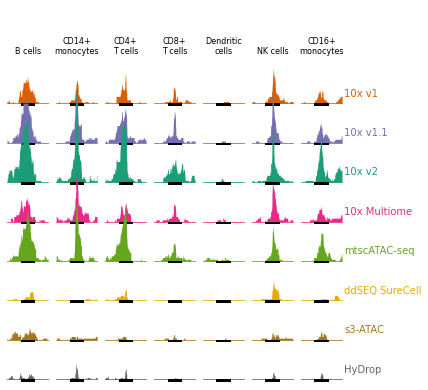

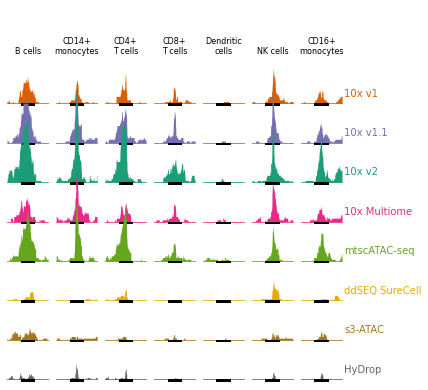

In [308]:
## create the gridspec
fig = plt.figure(figsize=figsize, facecolor="white")

# define ratios between all elements in the graphic
height_ratios = [0.2]  # for gtf
height_ratios.append(len(bw_path_dict_dict))  # for bws
height_ratios.append(0.1)  # for text box

# create a global frame for the 3 modalities shown (bigwigs, gtf, and text)
frame = gridspec.GridSpec(3, 1, wspace=0.25, hspace=0.17, height_ratios=height_ratios)

# create a gridspec for each modality within the frame
n_cols = len(regions_dict)
n_rows = len(tech_order)

text_grid = gridspec.GridSpecFromSubplotSpec(
    1, n_cols, wspace=0.2, hspace=0, subplot_spec=frame[0, 0]
)
bw_dar_grid = gridspec.GridSpecFromSubplotSpec(
    n_rows, n_cols, wspace=0.2, hspace=-0.6, subplot_spec=frame[1, 0]
)
gtf_grid = gridspec.GridSpecFromSubplotSpec(
    max_genes, n_cols, wspace=0.2, hspace=0, subplot_spec=frame[2, 0]
)

## iterate over all regions (=columns in final figure)
for region_name in cell_type_order:
    if verbose == True:
        print(f"drawing column for region {region_name}")
    region_index = cell_type_order.index(
        region_name
    )  # get the region index for column indexing

    # the genome coordinates over which we will be plotting:
    chrom = regions_df_padded.loc[region_name]["chrom"]
    start = int(regions_df_padded.loc[region_name]["start"])
    end = int(regions_df_padded.loc[region_name]["end"])
    x = np.array(range(start, end, 1))

    # set ymax according to region
    # bw_ymax = region_max_dict[region_name]

    # you can also set global ymax:
    bw_ymax = region_max_dict_padded[
        max(region_max_dict_padded, key=region_max_dict_padded.get)
    ]

    ## iterate over all bigwigs (=rows in final figure)
    for key in tech_order:
        if verbose == True:
            print(f"\t{key}: alias {tech_alias_dict[key]}")

        bw_index = tech_order.index(key)  # get the bw index for row indexing

        # create a new gridspec for bw + dar
        if "regions_dict_padded" in locals() or "peak_path_dict" in locals():
            bw_dar_subgrid = gridspec.GridSpecFromSubplotSpec(
                2,
                1,
                wspace=0.05,
                hspace=0,
                subplot_spec=bw_dar_grid[bw_index, region_index],
                height_ratios=[20, 0.5],
            )
        else:
            bw_dar_subgrid = gridspec.GridSpecFromSubplotSpec(
                1,
                1,
                wspace=0.05,
                hspace=0.2,
                subplot_spec=bw_dar_grid[bw_index, region_index],
            )

        # open the bigwig
        bw_file = bw_path_dict_dict[region_name][key]
        if verbose == True:
            print(f"\t\tbw: {bw_file}")

        bw = pyBigWig.open(bw_file)
        y = bw.values(chrom, start, end)
        y = np.nan_to_num(y)

        # now plot the bigwig in the gridspec
        ax = plt.Subplot(fig, bw_dar_subgrid[0, 0])
        ax.fill_between(
            x, y1=y, y2=0, step="mid", linewidth=0, color=tech_color_palette[key]
        )
        ax.patch.set_alpha(0)

        # figure settings
        ax.set_xlim([x.min(), x.max()])
        ax.set_ylim([0, bw_ymax])
        ax.set_xticks([])
        ax.set_yticks([])

        # add a ylabel only if it's the last column
        if region_name == cell_type_order[-1]:
            ax.yaxis.set_label_position("right")
            ax.set_ylabel(
                tech_alias_dict[key],
                rotation=0,
                horizontalalignment="left",
                verticalalignment="bottom",
                color=tech_color_palette[key],
            )
            ax.yaxis.set_label_coords(1.05, 0.05)

        # add a title only if it's the first row
        if tech_order.index(key) == 0:
            region = regions_dict_padded[region_name]
            length = round((end - start) / 1000)
            label = f"{cell_type_alias_dict[region_name]}"

            ax.set_title(label, fontsize=8, y=0.45)

        sns.despine(top=True, right=True, left=True, bottom=False, ax=ax)
        for spine in ax.spines.values():
            spine.set_edgecolor(tech_color_palette[key])

        # add to the fig
        fig.add_subplot(ax, transparent=True)

        # first draw peaks if they are defined
        if "peak_path_dict" in locals():
            # get peaks that overlap the region to be plotted
            peak = BedTool(peak_path_dict[region_name])
            peak_region_intersection = peak.intersect(
                BedTool.from_dataframe(df=regions_df_padded), wa=True, wb=True
            )
            peak_region_intersection = peak_region_intersection.to_dataframe(
                header=None
            )
            peak_region_intersection = peak_region_intersection.iloc[:, :4]
            peak_region_intersection.columns = "chr start end name".split()

            # now plot the dars in the gridspec
            ax = plt.Subplot(fig, bw_dar_subgrid[1, 0])
            for element in peak_region_intersection.index:
                part = peak_region_intersection.loc[element]
                peak_start = part["start"]
                peak_end = part["end"]

                # plot a thin line, with beginning and ending as x coordinates, and bw_ymin as y coordinates
                # NOTE: linewidth won't do much here, it is more determined by the 'space' you give to this part of the plot in height_ratios!
                ax.plot([peak_start, peak_end], [0, 0], linewidth=4, c=peak_color)

            # figure settings
            ax.set_ylim([-1, +1])
            addax()

        # then draw dars if they are defined
        if "regions_path_dict" in locals():
            # get DARs that overlap the region to be plotted
            dar = BedTool(regions_path_dict[region_name])
            if verbose == True:
                print(f"\t\tdar: {regions_path_dict[region_name]}")

            dar_region_intersection = dar.intersect(
                BedTool.from_dataframe(df=regions_df_padded), wa=True, wb=True
            )
            dar_region_intersection = dar_region_intersection.to_dataframe(header=None)
            dar_region_intersection = dar_region_intersection.iloc[:, :4]
            dar_region_intersection.columns = "chr start end name".split()

            # now plot the dars in the gridspec
            ax = plt.Subplot(fig, bw_dar_subgrid[1, 0])
            for element in dar_region_intersection.index:
                part = dar_region_intersection.loc[element]
                dar_start = part["start"]
                dar_end = part["end"]

                # plot a thin line, with beginning and ending as x coordinates, and bw_ymin as y coordinates
                # NOTE: linewidth won't do much here, it is more determined by the 'space' you give to this part of the plot in height_ratios!
                ax.plot([dar_start, dar_end], [0, 0], linewidth=4, c=dar_color)

            # figure settings
            ax.set_ylim([-1, +1])
            addax()

    ## draw the genes of interest, from our gtf
    # intersect genes gtf with the region of interest
    if plot_genes == True:
        gtf = BedTool(gtf_file)
        gtf_region_intersection = gtf.intersect(
            BedTool.from_dataframe(df=regions_df_padded), wa=True, wb=True
        )
        gtf_region_intersection = gtf_region_intersection.to_dataframe(header=None)
        gtf_region_intersection = gtf_region_intersection.iloc[:, :9]
        gtf_region_intersection.columns = (
            "chr db feature start end score strand frame attribute".split()
        )

        ## iterate over all genes of interest in genes_dict
        for gene in genes_dict[region_name]:
            gene_index = genes_dict[region_name].index(
                gene
            )  # get gene index for row indexing

            # get gtf intersection with only gene body and exons of this particular gene
            gtf_region_intersection_gene = gtf_region_intersection[
                gtf_region_intersection["attribute"].str.contains(gene)
            ]
            gtf_region_intersection_gene = gtf_region_intersection_gene[
                gtf_region_intersection_gene["feature"].str.contains("gene|exon")
            ]

            # now plot the gene parts (gene body and gene exon)
            ax = plt.Subplot(fig, gtf_grid[gene_index, region_index])

            # iterate over all parts to plot them
            for element in gtf_region_intersection_gene.index:
                part = gtf_region_intersection_gene.loc[element]

                # make exons thick
                if part["feature"] == "exon":
                    exon_start = part["start"]
                    exon_end = part["end"]
                    # draw rectangle for exon
                    rect = mpatches.Rectangle(
                        (exon_start, exon_bottom),
                        exon_end - exon_start,
                        exon_height,
                        fill=True,
                        color="k",
                        linewidth=0,
                    )
                    ax.add_patch(rect)

                # make the gene body a thin line, drawn at the end so it will always display on top
                elif part["feature"] == "gene":
                    gene_start = part["start"]
                    gene_end = part["end"]
                    rect = mpatches.Rectangle(
                        (gene_start, gene_bottom),
                        gene_end - gene_start,
                        gene_height,
                        fill=True,
                        color="k",
                        linewidth=0,
                    )
                    ax.add_patch(rect)

        if verbose == True:
            print(
                f"\tfor region {region_name}, drew gene {gene}, {len(gtf_region_intersection_gene.index)} individual items drawn\n"
            )

        # figure settings
        ax.set_ylim([exon_bottom, -exon_bottom])
        ax.set_xlabel(gene, fontsize=10)
        addax()

fig.savefig(
    "plts_track/dar_track__per_tech_harmony_cell_type_bigwigs_nonnorm.png",
    dpi=350,
    bbox_inches="tight",
    pad_inches=0,
    transparent=False,
    facecolor="white",
)
fig.savefig(
    "plts_track/dar_track__per_tech_harmony_cell_type_bigwigs_nonnorm.svg",
    dpi=350,
    bbox_inches="tight",
    pad_inches=0,
    transparent=False,
    facecolor="white",
)

fig

In [309]:
cell_type_alias_dict

{'B_cell': 'B cells',
 'CD14_monocyte': 'CD14+\nmonocytes',
 'CD4_T_cell': 'CD4+\nT cells',
 'Cytotoxic_T_cell': 'CD8+\nT cells',
 'Dendritic_cell': 'Dendritic\ncells',
 'Natural_killer_cell': 'NK cells',
 'CD16_monocyte': 'CD16+\nmonocytes'}

In [310]:
cell_type_order

['B_cell',
 'CD14_monocyte',
 'CD4_T_cell',
 'Cytotoxic_T_cell',
 'Dendritic_cell',
 'Natural_killer_cell',
 'CD16_monocyte']

# now do it for the "best" average rank DARs

In [311]:
merged_dar_path_dict = {
    x.split("/")[-1].split("__DARs.TOP2k.bed")[0]: x
    for x in glob.glob(
        "downstream_analysis/harmony_DARs/master_sub_1.FIXEDCELLS/master_sub_1.FIXEDCELLS__*TOP2k.bed"
    )
}
merged_dar_path_dict

{'master_sub_1.FIXEDCELLS__Cytotoxic_T_cell': 'downstream_analysis/harmony_DARs/master_sub_1.FIXEDCELLS/master_sub_1.FIXEDCELLS__Cytotoxic_T_cell__DARs.TOP2k.bed',
 'master_sub_1.FIXEDCELLS__CD14+_monocyte': 'downstream_analysis/harmony_DARs/master_sub_1.FIXEDCELLS/master_sub_1.FIXEDCELLS__CD14+_monocyte__DARs.TOP2k.bed',
 'master_sub_1.FIXEDCELLS__B_cell': 'downstream_analysis/harmony_DARs/master_sub_1.FIXEDCELLS/master_sub_1.FIXEDCELLS__B_cell__DARs.TOP2k.bed',
 'master_sub_1.FIXEDCELLS__CD16+_monocyte': 'downstream_analysis/harmony_DARs/master_sub_1.FIXEDCELLS/master_sub_1.FIXEDCELLS__CD16+_monocyte__DARs.TOP2k.bed',
 'master_sub_1.FIXEDCELLS__Dendritic_cell': 'downstream_analysis/harmony_DARs/master_sub_1.FIXEDCELLS/master_sub_1.FIXEDCELLS__Dendritic_cell__DARs.TOP2k.bed',
 'master_sub_1.FIXEDCELLS__Natural_killer_cell': 'downstream_analysis/harmony_DARs/master_sub_1.FIXEDCELLS/master_sub_1.FIXEDCELLS__Natural_killer_cell__DARs.TOP2k.bed',
 'master_sub_1.FIXEDCELLS__CD4+_T_cell': '

In [312]:
regions_dict = OrderedDict({})

for supersample, path in merged_dar_path_dict.items():
    print(supersample)
    df = pd.read_csv(path, sep="\t", header=None)
    df.columns = "chrom start end cell_type log2fc strand p_val".split()
    # print(df.iloc[0])

    cell_type = supersample.split("__")[-1]
    region = f"{df.iloc[0]['chrom']}:{df.iloc[0]['start']}-{df.iloc[0]['end']}"
    regions_dict[cell_type] = region

regions_dict

master_sub_1.FIXEDCELLS__Cytotoxic_T_cell
master_sub_1.FIXEDCELLS__CD14+_monocyte
master_sub_1.FIXEDCELLS__B_cell
master_sub_1.FIXEDCELLS__CD16+_monocyte
master_sub_1.FIXEDCELLS__Dendritic_cell
master_sub_1.FIXEDCELLS__Natural_killer_cell
master_sub_1.FIXEDCELLS__CD4+_T_cell


OrderedDict([('Cytotoxic_T_cell', 'chr9:75010514-75011014'),
             ('CD14+_monocyte', 'chr3:149373637-149374137'),
             ('B_cell', 'chr5:158898392-158898892'),
             ('CD16+_monocyte', 'chr13:48624875-48625375'),
             ('Dendritic_cell', 'chr7:115505120-115505620'),
             ('Natural_killer_cell', 'chr11:65694802-65695302'),
             ('CD4+_T_cell', 'chr3:3297025-3297525')])

In [313]:
regions_dict = {
    "B_cell": "chr9:105355788-105356288",
    "CD14+_monocyte": "chr13:20538552-20539052",
    "CD16+_monocyte": "chr2:127014597-127015097",
    "CD4+_T_cell": "chr1:120561744-120562244",
    "Cytotoxic_T_cell": "chr2:8260129-8260629",
    "Dendritic_cell": "chr1:73593354-73593854",
    "Natural_killer_cell": "chr14:81485274-81485774",
}

In [368]:
regions_dict = {
    "B_cell": "chr9:105355788-105356288",
    "CD14_monocyte": "chr13:73338358-73338858",
    "CD16_monocyte": "chr2:127014597-127015097",
    "CD4_T_cell": "chr13:26062788-26063288",
    "Cytotoxic_T_cell": "chr21:44829703-44830203",
    "Dendritic_cell": "chr6:72580326-72580826",
    "Natural_killer_cell": "chr6:168968153-168968653",
}

In [369]:
regions_df = pd.DataFrame(columns=["chrom", "start", "end"])
for key in regions_dict.keys():
    row = list(regions_dict.keys()).index(key)
    chrom, start, end = re.split(":|-", regions_dict[key])
    start = int(re.sub(",", "", start))
    end = int(re.sub(",", "", end))

    region = pd.DataFrame(columns=["chrom", "start", "end"], index=[key])
    region["chrom"] = chrom
    region["start"] = start
    region["end"] = end
    regions_df = pd.concat([regions_df, region], axis=0)

bedtool_obj = BedTool.from_dataframe(df=regions_df)

genes to plot

In [370]:
cell_types = list(
    set(
        [
            "_".join(x.split("/")[-1].split("_")[1:]).split(".")[0]
            for x in glob.glob(
                "per_tech_harmony_cell_type_bigwigs_nonnorm/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/*"
            )
        ]
    )
)

bw_path_dict_dict = {}
for cell_type in cell_types:
    # print(cell_type)
    bw_path_dict_dict[cell_type] = {
        x.split("/")[-1].split("_")[0]: x
        for x in glob.glob(
            f"per_tech_harmony_cell_type_bigwigs_nonnorm/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/*{cell_type}*"
        )
    }
bw_path_dict_dict

{'CD14_monocyte': {'10xv2': 'per_tech_harmony_cell_type_bigwigs_nonnorm/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/10xv2_CD14_monocyte.bw',
  'hydrop': 'per_tech_harmony_cell_type_bigwigs_nonnorm/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/hydrop_CD14_monocyte.bw',
  '10xmultiome': 'per_tech_harmony_cell_type_bigwigs_nonnorm/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/10xmultiome_CD14_monocyte.bw',
  'ddseq': 'per_tech_harmony_cell_type_bigwigs_nonnorm/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/ddseq_CD14_monocyte.bw',
  'mtscatac': 'per_tech_harmony_cell_type_bigwigs_nonnorm/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/mtscatac_CD14_monocyte.bw',
  's3atac': 'per_tech_harmony_cell_type_bigwigs_nonnorm/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/s3atac_CD14_monocyte.bw',
  '10xv11': 'per_tech_harmony_cell_type_bigwigs_nonnorm/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_b

In [371]:
dar_color = "b"
peak_color = "k"
gene_height = 3
gene_bottom = -gene_height / 2
exon_height = 6
exon_bottom = -exon_height / 2

figsize = (6, 8)

In [372]:
def addax():
    ax.set_xlim([x.min(), x.max()])
    sns.despine(top=True, right=True, left=True, bottom=True, ax=ax)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.patch.set_alpha(
        0
    )  # make sure that each individual subplot is transparent! otherwise the underlying plots won't be shown. this is important e.g. for the dar/peak visualisaton, since the DARs are drawn directly on top of the peaks. if the DAR plot is not transparent, no peaks will be visible!!

    fig.add_subplot(ax)

In [373]:
max_genes = 1

In [374]:
plot_genes = False
verbose = True

In [375]:
region_forced_length = 2000

regions_df_padded = regions_df.copy()

regions_df_padded["region_center"] = (
    regions_df_padded["start"]
    + (regions_df_padded["end"] - regions_df_padded["start"]) / 2
)


regions_df_padded["start"] = (
    regions_df_padded["region_center"] - region_forced_length / 2
)
regions_df_padded["start"] = [int(x) for x in regions_df_padded["start"]]
regions_df_padded["end"] = regions_df_padded["region_center"] + region_forced_length / 2
regions_df_padded["end"] = [int(x) for x in regions_df_padded["end"]]

In [376]:
## calculate bw_ymax per col
region_max_dict_padded = {}
for region_name in regions_df_padded.index:
    chrom = regions_df_padded.loc[region_name]["chrom"]
    start = int(regions_df_padded.loc[region_name]["start"])
    end = int(regions_df_padded.loc[region_name]["end"])

    bw_ymax_dict_dict = {}
    for cell_type in bw_path_dict_dict.keys():
        bw_ymax_dict = {}

        for tech in bw_path_dict_dict[cell_type].keys():
            bw_file = bw_path_dict_dict[cell_type][tech]

            # calculate max value of the bigwig within our region
            bw = pyBigWig.open(bw_file)
            y = bw.values(chrom, start, end)
            y = np.nan_to_num(y)

            bw_ymax_dict[tech] = y.max()

        bw_ymax_dict_dict[cell_type] = max(bw_ymax_dict.values())

    region_max_dict_padded[region_name] = bw_ymax_dict_dict[
        max(bw_ymax_dict_dict, key=bw_ymax_dict_dict.get)
    ]
    print(f"calculated max values within region {region_name}")

region_max_dict_padded

calculated max values within region B_cell
calculated max values within region CD14_monocyte
calculated max values within region CD16_monocyte
calculated max values within region CD4_T_cell
calculated max values within region Cytotoxic_T_cell
calculated max values within region Dendritic_cell
calculated max values within region Natural_killer_cell


{'B_cell': 20.0,
 'CD14_monocyte': 37.0,
 'CD16_monocyte': 41.0,
 'CD4_T_cell': 34.0,
 'Cytotoxic_T_cell': 31.0,
 'Dendritic_cell': 41.0,
 'Natural_killer_cell': 22.0}

In [377]:
regions_df_padded

,chrom,start,end,region_center
B_cell,chr9,105355038,105357038,105356038.0
CD14_monocyte,chr13,73337608,73339608,73338608.0
CD16_monocyte,chr2,127013847,127015847,127014847.0
CD4_T_cell,chr13,26062038,26064038,26063038.0
Cytotoxic_T_cell,chr21,44828953,44830953,44829953.0
Dendritic_cell,chr6,72579576,72581576,72580576.0
Natural_killer_cell,chr6,168967403,168969403,168968403.0


In [378]:
regions_dict_padded = OrderedDict({})

for supersample, path in merged_dar_path_dict.items():
    # print(supersample)
    df = pd.read_csv(path, sep="\t", header=None)
    df.columns = "chrom start end cell_type log2fc strand p_val".split()
    # print(df.iloc[0])

    cell_type = supersample.split("__")[-1].replace("+", "")
    region = f"{df.iloc[0]['chrom']}:{df.iloc[0]['start']- region_forced_length / 2}-{df.iloc[0]['end']+region_forced_length / 2}"
    regions_dict_padded[cell_type] = region

regions_dict_padded

OrderedDict([('Cytotoxic_T_cell', 'chr9:75009514.0-75012014.0'),
             ('CD14_monocyte', 'chr3:149372637.0-149375137.0'),
             ('B_cell', 'chr5:158897392.0-158899892.0'),
             ('CD16_monocyte', 'chr13:48623875.0-48626375.0'),
             ('Dendritic_cell', 'chr7:115504120.0-115506620.0'),
             ('Natural_killer_cell', 'chr11:65693802.0-65696302.0'),
             ('CD4_T_cell', 'chr3:3296025.0-3298525.0')])

In [379]:
bw_path_dict_dict.keys()

dict_keys(['CD14_monocyte', 'Dendritic_cell', 'CD16_monocyte', 'CD4_T_cell', 'B_cell', 'Natural_killer_cell', 'Cytotoxic_T_cell'])

In [380]:
regions_df_padded.index = [x.replace("+", "") for x in regions_df_padded.index]

In [381]:
peak_path_dict = {
    x.replace(
        "+", ""
    ): "final_consensus_peaks/master_sub_1.FIXEDCELLS__SCREEN_consensus_peaks.bed"
    for x in regions_dict.keys()
}
peak_path_dict

{'B_cell': 'final_consensus_peaks/master_sub_1.FIXEDCELLS__SCREEN_consensus_peaks.bed',
 'CD14_monocyte': 'final_consensus_peaks/master_sub_1.FIXEDCELLS__SCREEN_consensus_peaks.bed',
 'CD16_monocyte': 'final_consensus_peaks/master_sub_1.FIXEDCELLS__SCREEN_consensus_peaks.bed',
 'CD4_T_cell': 'final_consensus_peaks/master_sub_1.FIXEDCELLS__SCREEN_consensus_peaks.bed',
 'Cytotoxic_T_cell': 'final_consensus_peaks/master_sub_1.FIXEDCELLS__SCREEN_consensus_peaks.bed',
 'Dendritic_cell': 'final_consensus_peaks/master_sub_1.FIXEDCELLS__SCREEN_consensus_peaks.bed',
 'Natural_killer_cell': 'final_consensus_peaks/master_sub_1.FIXEDCELLS__SCREEN_consensus_peaks.bed'}

In [383]:
# merged_dar_path_dict = {
#     x.split("__")[1].replace("+", ""): y for x, y in merged_dar_path_dict.items()
# }

In [384]:
peak_path_dict = merged_dar_path_dict

In [385]:
set(regions_df_padded.index) == set(regions_dict_padded.keys()) == set(
    bw_path_dict_dict.keys()
) == set(peak_path_dict.keys())

True

In [386]:
regions_df_padded

,chrom,start,end,region_center
B_cell,chr9,105355038,105357038,105356038.0
CD14_monocyte,chr13,73337608,73339608,73338608.0
CD16_monocyte,chr2,127013847,127015847,127014847.0
CD4_T_cell,chr13,26062038,26064038,26063038.0
Cytotoxic_T_cell,chr21,44828953,44830953,44829953.0
Dendritic_cell,chr6,72579576,72581576,72580576.0
Natural_killer_cell,chr6,168967403,168969403,168968403.0


In [387]:
genes_dict = {
    "Cytotoxic_T_cell": [],
    "CD14_monocyte": [],
    "B_cell": ["EBF1"],
    "CD16_monocyte": [],
    "Dendritic_cell": [],
    "Natural_killer_cell": [],
    "CD4_T_cell": [],
}
max_genes = max([len((genes_dict[key])) for key in genes_dict.keys()])

gtf_file = "/lustre1/project/stg_00090/scatac_benchmark/0_resources/genomes/hg38_cflerin_cellranger_arc/genes.ucsc.gtf"

In [388]:
plot_genes = False

In [389]:
regions_df_padded

,chrom,start,end,region_center
B_cell,chr9,105355038,105357038,105356038.0
CD14_monocyte,chr13,73337608,73339608,73338608.0
CD16_monocyte,chr2,127013847,127015847,127014847.0
CD4_T_cell,chr13,26062038,26064038,26063038.0
Cytotoxic_T_cell,chr21,44828953,44830953,44829953.0
Dendritic_cell,chr6,72579576,72581576,72580576.0
Natural_killer_cell,chr6,168967403,168969403,168968403.0


In [390]:
height_ratios

[0.2, 7, 0.1]

drawing column for region B_cell
	10xv1: alias 10x v1
		bw: per_tech_harmony_cell_type_bigwigs_nonnorm/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/10xv1_B_cell.bw
	10xv11: alias 10x v1.1
		bw: per_tech_harmony_cell_type_bigwigs_nonnorm/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/10xv11_B_cell.bw
	10xv2: alias 10x v2
		bw: per_tech_harmony_cell_type_bigwigs_nonnorm/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/10xv2_B_cell.bw
	10xmultiome: alias 10x Multiome
		bw: per_tech_harmony_cell_type_bigwigs_nonnorm/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/10xmultiome_B_cell.bw
	mtscatac: alias mtscATAC-seq
		bw: per_tech_harmony_cell_type_bigwigs_nonnorm/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/mtscatac_B_cell.bw
	ddseq: alias ddSEQ SureCell
		bw: per_tech_harmony_cell_type_bigwigs_nonnorm/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/ddseq_B_cell.bw
	s3atac: alias s3-ATAC
		bw: pe

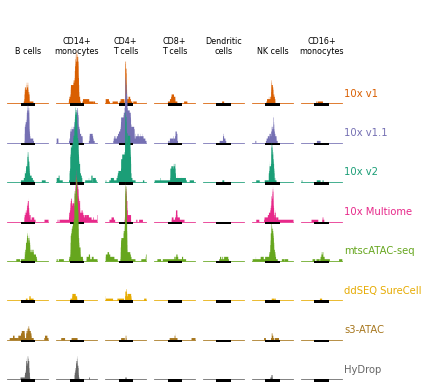

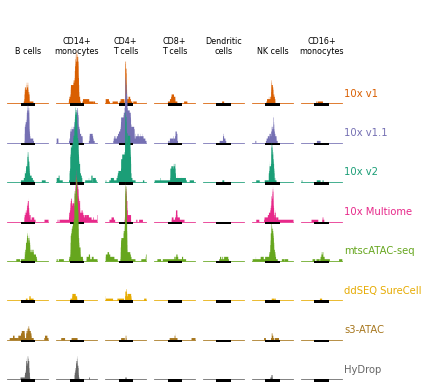

In [391]:
## create the gridspec
fig = plt.figure(figsize=figsize, facecolor="white")

# define ratios between all elements in the graphic
height_ratios = [0.2]  # for gtf
height_ratios.append(len(bw_path_dict_dict))  # for bws
height_ratios.append(0.1)  # for text box

# create a global frame for the 3 modalities shown (bigwigs, gtf, and text)
frame = gridspec.GridSpec(3, 1, wspace=0.25, hspace=0.17, height_ratios=height_ratios)

# create a gridspec for each modality within the frame
n_cols = len(regions_dict)
n_rows = len(tech_order)

text_grid = gridspec.GridSpecFromSubplotSpec(
    1, n_cols, wspace=0.2, hspace=0, subplot_spec=frame[0, 0]
)
bw_dar_grid = gridspec.GridSpecFromSubplotSpec(
    n_rows, n_cols, wspace=0.2, hspace=-0.6, subplot_spec=frame[1, 0]
)
gtf_grid = gridspec.GridSpecFromSubplotSpec(
    max_genes, n_cols, wspace=0.2, hspace=0, subplot_spec=frame[2, 0]
)

## iterate over all regions (=columns in final figure)
for region_name in cell_type_order:
    if verbose == True:
        print(f"drawing column for region {region_name}")
    region_index = cell_type_order.index(
        region_name
    )  # get the region index for column indexing

    # the genome coordinates over which we will be plotting:
    chrom = regions_df_padded.loc[region_name]["chrom"]
    start = int(regions_df_padded.loc[region_name]["start"])
    end = int(regions_df_padded.loc[region_name]["end"])
    x = np.array(range(start, end, 1))

    # set ymax according to region
    # bw_ymax = region_max_dict[region_name]

    # you can also set global ymax:
    bw_ymax = region_max_dict_padded[
        max(region_max_dict_padded, key=region_max_dict_padded.get)
    ]

    ## iterate over all bigwigs (=rows in final figure)
    for key in tech_order:
        if verbose == True:
            print(f"\t{key}: alias {tech_alias_dict[key]}")

        bw_index = tech_order.index(key)  # get the bw index for row indexing

        # create a new gridspec for bw + dar
        if "regions_dict_padded" in locals() or "peak_path_dict" in locals():
            bw_dar_subgrid = gridspec.GridSpecFromSubplotSpec(
                2,
                1,
                wspace=0.05,
                hspace=0,
                subplot_spec=bw_dar_grid[bw_index, region_index],
                height_ratios=[20, 0.5],
            )
        else:
            bw_dar_subgrid = gridspec.GridSpecFromSubplotSpec(
                1,
                1,
                wspace=0.05,
                hspace=0.2,
                subplot_spec=bw_dar_grid[bw_index, region_index],
            )

        # open the bigwig
        bw_file = bw_path_dict_dict[region_name][key]
        if verbose == True:
            print(f"\t\tbw: {bw_file}")

        bw = pyBigWig.open(bw_file)
        y = bw.values(chrom, start, end)
        y = np.nan_to_num(y)

        # now plot the bigwig in the gridspec
        ax = plt.Subplot(fig, bw_dar_subgrid[0, 0])
        ax.fill_between(
            x, y1=y, y2=0, step="mid", linewidth=0, color=tech_color_palette[key]
        )
        ax.patch.set_alpha(0)

        # figure settings
        ax.set_xlim([x.min(), x.max()])
        ax.set_ylim([0, bw_ymax])
        ax.set_xticks([])
        ax.set_yticks([])

        # add a ylabel only if it's the last column
        if region_name == cell_type_order[-1]:
            ax.yaxis.set_label_position("right")
            ax.set_ylabel(
                tech_alias_dict[key],
                rotation=0,
                horizontalalignment="left",
                verticalalignment="bottom",
                color=tech_color_palette[key],
            )
            ax.yaxis.set_label_coords(1.05, 0.05)

        # add a title only if it's the first row
        if tech_order.index(key) == 0:
            region = regions_dict_padded[region_name]
            length = round((end - start) / 1000)
            label = f"{cell_type_alias_dict[region_name]}"

            ax.set_title(label, fontsize=8, y=0.45)

        sns.despine(top=True, right=True, left=True, bottom=False, ax=ax)
        for spine in ax.spines.values():
            spine.set_edgecolor(tech_color_palette[key])

        # add to the fig
        fig.add_subplot(ax, transparent=True)

        # first draw peaks if they are defined
        if "peak_path_dict" in locals():
            # get peaks that overlap the region to be plotted
            peak = BedTool(peak_path_dict[region_name])
            peak_region_intersection = peak.intersect(
                BedTool.from_dataframe(df=regions_df_padded), wa=True, wb=True
            )
            peak_region_intersection = peak_region_intersection.to_dataframe(
                header=None
            )
            peak_region_intersection = peak_region_intersection.iloc[:, :4]
            peak_region_intersection.columns = "chr start end name".split()

            # now plot the dars in the gridspec
            ax = plt.Subplot(fig, bw_dar_subgrid[1, 0])
            for element in peak_region_intersection.index:
                part = peak_region_intersection.loc[element]
                peak_start = part["start"]
                peak_end = part["end"]

                # plot a thin line, with beginning and ending as x coordinates, and bw_ymin as y coordinates
                # NOTE: linewidth won't do much here, it is more determined by the 'space' you give to this part of the plot in height_ratios!
                ax.plot([peak_start, peak_end], [0, 0], linewidth=4, c=peak_color)

            # figure settings
            ax.set_ylim([-1, +1])
            addax()

        # then draw dars if they are defined
        if "regions_path_dict" in locals():
            # get DARs that overlap the region to be plotted
            dar = BedTool(regions_path_dict[region_name])
            if verbose == True:
                print(f"\t\tdar: {regions_path_dict[region_name]}")

            dar_region_intersection = dar.intersect(
                BedTool.from_dataframe(df=regions_df_padded), wa=True, wb=True
            )
            dar_region_intersection = dar_region_intersection.to_dataframe(header=None)
            dar_region_intersection = dar_region_intersection.iloc[:, :4]
            dar_region_intersection.columns = "chr start end name".split()

            # now plot the dars in the gridspec
            ax = plt.Subplot(fig, bw_dar_subgrid[1, 0])
            for element in dar_region_intersection.index:
                part = dar_region_intersection.loc[element]
                dar_start = part["start"]
                dar_end = part["end"]

                # plot a thin line, with beginning and ending as x coordinates, and bw_ymin as y coordinates
                # NOTE: linewidth won't do much here, it is more determined by the 'space' you give to this part of the plot in height_ratios!
                ax.plot([dar_start, dar_end], [0, 0], linewidth=4, c=dar_color)

            # figure settings
            ax.set_ylim([-1, +1])
            addax()

    ## draw the genes of interest, from our gtf
    # intersect genes gtf with the region of interest
    if plot_genes == True:
        gtf = BedTool(gtf_file)
        gtf_region_intersection = gtf.intersect(
            BedTool.from_dataframe(df=regions_df_padded), wa=True, wb=True
        )
        gtf_region_intersection = gtf_region_intersection.to_dataframe(header=None)
        gtf_region_intersection = gtf_region_intersection.iloc[:, :9]
        gtf_region_intersection.columns = (
            "chr db feature start end score strand frame attribute".split()
        )

        ## iterate over all genes of interest in genes_dict
        for gene in genes_dict[region_name]:
            gene_index = genes_dict[region_name].index(
                gene
            )  # get gene index for row indexing

            # get gtf intersection with only gene body and exons of this particular gene
            gtf_region_intersection_gene = gtf_region_intersection[
                gtf_region_intersection["attribute"].str.contains(gene)
            ]
            gtf_region_intersection_gene = gtf_region_intersection_gene[
                gtf_region_intersection_gene["feature"].str.contains("gene|exon")
            ]

            # now plot the gene parts (gene body and gene exon)
            ax = plt.Subplot(fig, gtf_grid[gene_index, region_index])

            # iterate over all parts to plot them
            for element in gtf_region_intersection_gene.index:
                part = gtf_region_intersection_gene.loc[element]

                # make exons thick
                if part["feature"] == "exon":
                    exon_start = part["start"]
                    exon_end = part["end"]
                    # draw rectangle for exon
                    rect = mpatches.Rectangle(
                        (exon_start, exon_bottom),
                        exon_end - exon_start,
                        exon_height,
                        fill=True,
                        color="k",
                        linewidth=0,
                    )
                    ax.add_patch(rect)

                # make the gene body a thin line, drawn at the end so it will always display on top
                elif part["feature"] == "gene":
                    gene_start = part["start"]
                    gene_end = part["end"]
                    rect = mpatches.Rectangle(
                        (gene_start, gene_bottom),
                        gene_end - gene_start,
                        gene_height,
                        fill=True,
                        color="k",
                        linewidth=0,
                    )
                    ax.add_patch(rect)

        if verbose == True:
            print(
                f"\tfor region {region_name}, drew gene {gene}, {len(gtf_region_intersection_gene.index)} individual items drawn\n"
            )

        # figure settings
        ax.set_ylim([exon_bottom, -exon_bottom])
        ax.set_xlabel(gene, fontsize=10)
        addax()

fig.savefig(
    "plts_track/dar_best_track__per_tech_harmony_cell_type_bigwigs_nonnorm.png",
    dpi=350,
    bbox_inches="tight",
    pad_inches=0,
    transparent=False,
    facecolor="white",
)
fig.savefig(
    "plts_track/dar_best_track__per_tech_harmony_cell_type_bigwigs_nonnorm.svg",
    dpi=350,
    bbox_inches="tight",
    pad_inches=0,
    transparent=False,
    facecolor="white",
)

fig

In [392]:
bw_path_dict_dict[region_name]

{'10xv1': 'per_tech_harmony_cell_type_bigwigs_nonnorm/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/10xv1_CD16_monocyte.bw',
 'mtscatac': 'per_tech_harmony_cell_type_bigwigs_nonnorm/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/mtscatac_CD16_monocyte.bw',
 'hydrop': 'per_tech_harmony_cell_type_bigwigs_nonnorm/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/hydrop_CD16_monocyte.bw',
 '10xmultiome': 'per_tech_harmony_cell_type_bigwigs_nonnorm/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/10xmultiome_CD16_monocyte.bw',
 's3atac': 'per_tech_harmony_cell_type_bigwigs_nonnorm/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/s3atac_CD16_monocyte.bw',
 '10xv2': 'per_tech_harmony_cell_type_bigwigs_nonnorm/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/10xv2_CD16_monocyte.bw',
 'ddseq': 'per_tech_harmony_cell_type_bigwigs_nonnorm/master_sub_1.FIXEDCELLS__CONSENSUS_pseudobulk_bw_files_nonnorm/ddseq_CD1

In [393]:
cell_type_order

['B_cell',
 'CD14_monocyte',
 'CD4_T_cell',
 'Cytotoxic_T_cell',
 'Dendritic_cell',
 'Natural_killer_cell',
 'CD16_monocyte']